Interesting Kernels:
> Xhulu's kernel: https://www.kaggle.com/xhlulu/ieee-fraud-xgboost-with-gpu-fit-in-40s

> EDA: https://www.kaggle.com/jesucristo/fraud-complete-eda

> Extensive EDA: https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt

> Insights of data: https://www.kaggle.com/c/ieee-fraud-detection/discussion/100002#latest-578111

> EDA, Drop Nans and Feature Engineering: https://www.kaggle.com/artgor/eda-and-models

> Class Imbalance: https://www.kaggle.com/shahules/tackling-class-imbalance

In [1]:
%%time
### Download Data
import kaggle

kaggle.api.competition_download_files('ieee-fraud-detection',path='./ieee-fraud-detection/input')

CPU times: user 295 ms, sys: 62.4 ms, total: 358 ms
Wall time: 4.46 s


In [2]:
import os
import time

import numpy as np
import pandas as pd
import scipy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn import pipeline
from sklearn.pipeline import *
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import *
import sklearn

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns

# Home Made Packages
from featgen_transformers import ColSelector,GradientBoostingFeatureGenerator
from sklearn_utils import *

# Encoder
import category_encoders

# Data


In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target ```isFraud```.

The data is broken into two files **identity** and **transaction**, which are joined by ```TransactionID```. 

> Note: Not all transactions have corresponding identity information.

**Categorical Features - Transaction**

- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

**Categorical Features - Identity**

- DeviceType
- DeviceInfo
- id_12 - id_38

**The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).**

**Files**

- train_{transaction, identity}.csv - the training set
- test_{transaction, identity}.csv - the test set (**you must predict the isFraud value for these observations**)
- sample_submission.csv - a sample submission file in the correct format


## Load Data

In [3]:
%%time
#pip install datatable
import datatable as dt
import time
t1 = time.time()
folder_path = './ieee-fraud-detection/input/'

# parse all files
train_identity = dt.fread(f'{folder_path}train_identity.csv.zip')
test_identity = dt.fread(f'{folder_path}test_identity.csv.zip')
train_transaction = dt.fread(f'{folder_path}train_transaction.csv.zip')
test_transaction = dt.fread(f'{folder_path}test_transaction.csv.zip')
sample_submission = pd.read_csv('./ieee-fraud-detection/input/sample_submission.csv.zip', index_col='TransactionID')
t2 = time.time()
print("Time to parse: %f" % (t2 - t1))

# join frames
train_identity.key = 'TransactionID'
test_identity.key = 'TransactionID'
train = train_transaction[:, :, dt.join(train_identity)]
test = test_transaction[:, :, dt.join(test_identity)]
t3 = time.time()
print("Time to join: %f" % (t3 - t2))

# turn datatable into Pandas frames
train_df = train.to_pandas()
test_df = test.to_pandas()
t4 = time.time()
print("Time to convert: %f" % (t4 - t3))

print("Total time: %f" % (t4 - t1))
print(train_df.shape)
print(test_df.shape)


Time to parse: 19.069032                                                        
Time to join: 0.318520
Time to convert: 12.395054
Total time: 31.782606
(590540, 434)
(506691, 433)
CPU times: user 27.4 s, sys: 14.7 s, total: 42.1 s
Wall time: 31.9 s


In [4]:
%%time
train_df['train']=1
test_df['train']=0

df = train_df.append(test_df)

# Separate the domain and extension of the mails and create two different columns. FillNa.
df = df.rename(columns={'isFraud':'target'})

/Users/cmougan/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


CPU times: user 18.2 s, sys: 43 s, total: 1min 1s
Wall time: 59.1 s


In [5]:
# Erase the not usefull stuff
del train_df,test_df,train_identity,test_identity,train_transaction,test_transaction,train,test

### Subsampling the data

In [6]:
df = df.sample(n=1500)
df.shape

(1500, 435)

In [7]:
## Separating Back
X_train = df.query('train==1').drop(columns='target')
y_train = df.query('train==1')['target']
X_test = df.query('train==0').drop(columns='target')

In [8]:
# GPreda, missing data
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))
missing_data(df)

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,C6,C7,C8,C9,D1,D10,D11,D12,D13,D14,D15,D2,D3,D4,D5,D6,D7,D8,D9,DeviceInfo,DeviceType,M1,M2,M3,M4,M5,M6,M7,M8,M9,P_emaildomain,ProductCD,R_emaildomain,TransactionAmt,TransactionDT,TransactionID,V1,V10,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V11,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V12,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V13,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V14,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V15,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V16,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V17,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V18,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V19,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V2,V20,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V21,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V22,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V23,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V24,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V25,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V26,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V27,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V28,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V29,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V3,V30,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V31,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V32,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V33,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,V34,V35,V36,V37,V38,V39,V4,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V5,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V6,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V7,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V8,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V9,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,addr1,addr2,card1,card2,card3,card4,card5,card6,dist1,dist2,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,target,train
Total,0,0,0,0,8,0,0,0,0,0,0,0,0,0,12,117,603,1327,1251,1257,135,701,664,327,741,1229,1385,1312,1312,1119,1119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,603,603,1,1,1,1,1,1,1,1,1,1,603,1,1,1,1,1,1,1,1,1,1,117,1,1,1,1,1,1,1,1,1,1,117,1,1,1,1,1,1,1,1,1280,1280,117,1280,1280,1280,1280,1280,1280,1280,1280,1280,1280,117,1280,1280,1280,1280,1280,1280,1280,1280,1280,1280,117,1280,1280,1280,1280,1280,1280,1280,1133,1133,1133,117,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,117,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,117,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,603,117,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,117,1133,1133,1133,1133,1133,1133,1133,1155,1155,1155,117,1128,1128,1128,1155,1155,1155,1155,1128,1155,1155,117,1155,1155,1155,1155,1128,1155,1155,1155,1128,1128,117,1155,1155,1155,1155,1155,1128,1155,1155,1155,1155,117,1128,1128,1155,1155,1155,1128,1128,1155,1155,1128,117,1155,1155,1155,1155,1155,1155,1155,1155,1155,1155,117,1128,1128,1128,1155,1155,1155,1155,1155,1155,0,117,0,12,12,12,0,0,0,0,12,12,117,0,0,0,0,0,0,12,0,0,0,603,117,12,12,0,0,0,0,0,0,0,0,117,0,0,0,12,12,12,0,0,0,0,117,0,0,1280,1280,1280,1280,1280,1280,1280,1280,117,1280,1280,1280,1280,1280,1280,1280,1280,1280,1280,117,327,327,327,327,327,603,327,327,327,327,327,327,327,327,327,327,603,327,327,327,120,120,120,120,120,120,120,603,120,120,120,120,120,120,120,120,120,120,603,120,120,120,120,120,135,135,135,135,135,603,135,135,135,135,135,135,135,135,135,135,603,135,135,135,135,135,1,1,1,1,1,170,170,0,20,4,0,9,0,859,1405,1119,1131,1329,1329,1140,1140,1486,1486,1312,1312,1131,1119,1163,1288,1119,1119,1136,1380,1136,1137,1486,1486,1119,1487,1486,1486,1119,1119,1119,1119,1119,1293,1119,1119,1119,1119,1119,1119,713,0
Percent,0,0,0,0,0.533333,0,0,0,0,0,0,0,0,0,0.8,7.8,40.2,88.4667,83.4,83.8,9,46.7333,44.2667,21.8,49.4,81.9333,92.3333,87.4667,87.4667,74.6,74.6,0,0,0,0,0,0,0,0,0,0

## Drop all columns with an unique value

- convertir a columna entera toda columna con pocos valors


- si columna c es de valores reales hacer c, c_nan

ej: 0.2,

- si columna c es de valores enteros y nans hacer one hot encoding i añadir colum nan







## Create features Based on Nan Values

Columns created:

- Has Nan o no

- Mean

- Median

- Mode

- Std

- Skew

- Kurtosis

In [9]:
# Update column names
predictors = list(df.columns.difference(['target']))

# Get some basic meta features
df['cols_mean'] = df[predictors].replace(0, np.NaN).mean(axis=1)
df['cols_count'] = df[predictors].replace(0, np.NaN).count(axis=1)
df['cols_sum'] = df[predictors].replace(0, np.NaN).sum(axis=1)
df['cols_std'] = df[predictors].replace(0, np.NaN).std(axis=1)

/Users/cmougan/anaconda3/lib/python3.6/site-packages/pandas/core/missing.py:51: RuntimeWarning: invalid value encountered in equal
  mask = arr == x


In [10]:
def contains_nan(df_col):
    '''
    This functions checks if a certain column has nans
    '''
    return df_col.isna().any()

In [11]:
def create_cols_for_cols_with_nans(df, inplace=False):
    '''
    This function applied to a dataframe returns a list with the columns with NaNs
    and also returns a data frame with a column with 1 if value is NaN else 0 for all the columns with nans.
    '''
    if inplace:
        cols_with_nan = []
        for c in df.columns:
            if contains_nan(df[c]):
                cols_with_nan.append(c)
                df[c + "_nan"] = df[c].isna().values        
        return cols_with_nan
    else:
        df_copy = df.copy(deep=True)
        cols_with_nan = []
        for c in df.columns:
            if contains_nan(df[c]):
                cols_with_nan.append(c)
                df_copy[c + "_nan"] = df[c].isna().values
        return cols_with_nan, df_copy


In [12]:
def create_statististical_columns_for_nans(df,do_mean=True,do_median=True,do_mode=True,
                                           do_skew=True,do_kurtosis=True,do_std=True):
    df_copy = df.copy(deep=True)
    cols_with_nan = []
    for c in df.columns:
        if contains_nan(df[c]):
            if do_mean and df[c].dtype !='object':
                media = df[c].mean()
                df_copy[c+'_nan_mean'] = df[c].apply(lambda x: media if np.isnan(x) else 0)
            if do_median and df[c].dtype !='object':
                mediana = df[c].median()
                df_copy[c+'_nan_median'] = df[c].apply(lambda x: mediana if np.isnan(x) else 0)
            if do_mode:
                moda = df[c].mode()
                print(c)
                print(moda)
                #import pdb;pdb.set_trace()
                #df_copy[c + '_nan_mode'] = df[c].apply(lambda x: moda[0] if np.isnan(x) else 0)
            
            if do_std and df[c].dtype !='object':
                deviation = df[c].std()
                df_copy[c+'_nan_std'] = df[c].apply(lambda x: deviation if np.isnan(x) else 0)
            
            
            if do_skew and df[c].dtype !='object':
                skew = df[c].skew()
                df_copy[c+'_nan_skew'] = df[c].apply(lambda x: skew if np.isnan(x) else 0)
                
            if do_kurtosis and df[c].dtype !='object':
                kurtosis = scipy.stats.kurtosis(df[c].dropna())
                df_copy[c+'_nan_kurtosis'] = df[c].apply(lambda x: kurtosis if np.isnan(x) else 0)
                
                
    return df_copy
            

In [13]:
df.shape

(1500, 439)

In [14]:
df = create_statististical_columns_for_nans(df,do_mean=False,
                                           do_median=False,
                                           do_mode=False,
                                           do_skew=False,
                                           do_kurtosis=False,
                                           do_std=False)
df.shape

(1500, 439)

In [15]:
cols_with_nans, df = create_cols_for_cols_with_nans(df, inplace=False)

In [16]:
df.shape

(1500, 810)

## Encodings

In [19]:
class Encodings(BaseEstimator, TransformerMixin):
    '''
    This class implements fit and transform methods that allows to encode categorical features in different ways.
    
    '''
    
    def __init__(self, encoding_type="TargetEncoder",columns="All",return_categorical=True):
        #cols: list -> a list of columns to encode, if All, all string columns will be encoded.
        
        self._allowed_encodings = ["TargetEncoder","WOEEncoder","CatBoostEncoder","OneHotEncoder"]   
        
        
        assert encoding_type in self._allowed_encodings, "the encoding type introduced {} is not valid. Please use one in {}".format(encoding_type, self._allowed_encodings)
        self.encoding_type = encoding_type
        
        self.columns = columns
        self.return_categorical = return_categorical
        
        
    def fit(self,X,y):
        
        #import pdb;pdb.set_trace()
        
        
        # Obtain a list of categorical variables
        if self.columns == "All":
            self.categorical_cols = X.columns[X.dtypes==object].tolist()
        else:
            self.categorical_cols = self.columns
    

        # Split the data into categorical and numerical
        self.data_encode = X[[self.categorical_cols]]
        
        
        # Select the type of encoder
        if self.encoding_type == "TargetEncoder":
            self.enc = category_encoders.target_encoder.TargetEncoder()
        if self.encoding_type == "WOEEncoder":
            self.enc = category_encoders.woe.WOEEncoder()
        if self.encoding_type == "CatBoostEncoder":
            #This is very similar to leave-one-out encoding, 
            #but calculates the values “on-the-fly”.
            #Consequently, the values naturally vary during the training phase and it is not necessary to add random noise.
            # Needs to be randomly permuted
            # Random permutation
            perm = np.random.permutation(len(X))
            self.data_encode = self.data_encode.iloc[perm].reset_index(drop=True)
            y = y.iloc[perm].reset_index(drop=True)
            self.enc = category_encoders.cat_boost.CatBoostEncoder()
        if self.encoding_type == "OneHotEncoder":
            self.enc = category_encoders.one_hot.OneHotEncoder()
            
            # Check if all columns have certain number of elements bf OHE
            new_list=[]
            for col in self.data_encode.columns:
                if len(self.data_encode[col].unique())<50:
                    new_list.append(col)
                    
            self.data_encode = self.data_encode[new_list]
                
        
            


        

        
        # Fit the encoder
        self.enc.fit(self.data_encode,y)
        return self

    def transform(self, X):
        
        # Transform the data
        self.transformed = self.enc.transform(self.data_encode)
        
        # Modify the names of the columns with the proper suffix
        self.new_names = []
        for c in self.transformed.columns:
            self.new_names.append(c+'_'+self.encoding_type)
        self.transformed.columns = self.new_names
         
        if self.return_categorical:
            return self.transformed.join(X)
        else:
            return self.transformed.join(X)._get_numeric_data()
            


## Nan Inplacement

In [20]:
class NaNtreatment(BaseEstimator, TransformerMixin):
    '''
    This class implements a fit and transform methods that enables to implace NaNs in different ways.
    '''
    
    
    def __init__(self, treatment="mean"):
        
        
        #self._allowed_treatments = ["fixed_value", "mean",'median','mode','None']     
        #assert treatment in self._allowed_treatments,            "the treatment introduced {} is not valid. Please use one in {}".format(treatment, self._allowed_treatments)
        self.treatment = treatment

    
    def fit(self,X,y):
        
        #import pdb;pdb.set_trace()
        
        if self.treatment == "mean" or self.treatment==None:
            self.treatment_method = sklearn.impute.SimpleImputer(missing_values=np.nan, strategy='mean')
        elif self.treatment == "median":
            self.treatment_method = sklearn.impute.SimpleImputer(missing_values=np.nan, strategy='median')
        elif self.treatment == "most_frequent":
            self.treatment_method = sklearn.impute.SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            
        elif isinstance(self.treatment, (int,float)):
            self.treatment_method = sklearn.impute.SimpleImputer(missing_values=np.nan,
                                                                 strategy="constant",fill_value=self.treatment)       
        
        self.treatment_method.fit(X)
        return self

    def transform(self, X):
        if self.treatment==None:
            return X
        return self.treatment_method.transform(X)

### Reducing Memory

In [22]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
df = reduce_mem_usage(df)

Memory usage of dataframe is 5.55 MB
Memory usage after optimization is: 2.40 MB
Decreased by 56.7%
CPU times: user 668 ms, sys: 61.4 ms, total: 730 ms
Wall time: 748 ms


# Train Test Split

The train test split is made by time. 
Kernel (https://www.kaggle.com/c/ieee-fraud-detection/discussion/100057#latest-577194)

Someone found that oversampling allows a better CV

### TranSactionDT


> **The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).**

**Important ! read the post [The timespan of the dataset is 1 year ?
](https://www.kaggle.com/c/ieee-fraud-detection/discussion/100071#latest-577632) by Suchith**

```
Train: min = 86400 max = 15811131
Test: min = 18403224 max = 34214345
```

The difference train.min() and test.max() is ```x = 34214345 - 86400 = 34127945``` but we don't know is it in seconds,minutes or hours.

```
Time span of the total dataset is 394.9993634259259 days
Time span of Train dataset is  181.99920138888888 days
Time span of Test dataset is  182.99908564814814 days
The gap between train and test is 30.00107638888889 days
```

If it is in seconds then dataset timespan will be ```x/(3600*24*365) = 1.0821``` years which seems reasonable to me. So if the **transactionDT** is in **seconds** then

```
Time span of the total dataset is 394.9993634259259 days
Time span of Train dataset is  181.99920138888888 days
Time span of Test dataset is  182.99908564814814 days
The gap between train and test is 30.00107638888889 days
```


![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F2370491%2Fc9bf5af5e902595b737df5470adc193b%2Fdownload-1.png?generation=1563312982845419&alt=media)

**source: [FChmiel](https://www.kaggle.com/fchmiel)**
<br>

I believe the TransactionDT column is measured in seconds, starting at December 1.

The time span of the TransactionDT column is indeed a year and a month, missing 1 month inbetween train and test, so both train and test contain exactly half a year of data. There are peaks in the number of transactions at around 25 days and around 390 days (exactly 365 days later), which could be caused by increased sales around the christmas period. The test data ends exactly at the 31st of December, when choosing December 1 as starting date.

I made a kernel that visualizes the TransactionDT column assuming the starting date is 2017-12-01: https://www.kaggle.com/kevinbonnes/transactiondt-startdate

We could use this information to create features such as weekday and hour, they might provide information for our models.
Extracted from (https://www.kaggle.com/c/ieee-fraud-detection/discussion/100071#latest-577725)

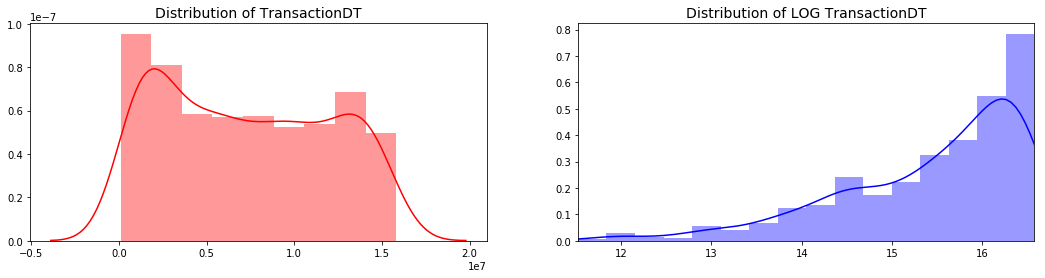

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = X_train['TransactionDT'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionDT', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionDT', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

In [24]:
# From https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
def make_day_feature(df, offset=0, tname='TransactionDT'):
    """
    Creates a day of the week feature, encoded as 0-6. 
    
    Parameters:
    -----------
    df : pd.DataFrame
        df to manipulate.
    offset : float (default=0)
        offset (in days) to shift the start/end of a day.
    tname : str
        Name of the time column in df.
    """
    # found a good offset is 0.58
    days = df[tname] / (3600*24)        
    encoded_days = np.floor(days-1+offset) % 7
    return encoded_days

def make_hour_feature(df, tname='TransactionDT'):
    """
    Creates an hour of the day feature, encoded as 0-23. 
    
    Parameters:
    -----------
    df : pd.DataFrame
        df to manipulate.
    tname : str
        Name of the time column in df.
    """
    hours = df[tname] / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

df['hour'] = make_hour_feature(df)
df['day'] = make_day_feature(df)

# Imbalanced Data

Notice how **imbalanced** is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

**Imbalance** means that the number of data points available for different the classes is different

<img src='https://www.datascience.com/hs-fs/hubfs/imbdata.png?t=1542328336307&width=487&name=imbdata.png'>

We have to determine wether we want to upsample or Downsample. And the technique we want to use. Could it be implemented in a pipeline? 

In [25]:
import imblearn

/Users/cmougan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Oversampling Techniques:
> **RandomOverSample**: Object to over-sample the minority class(es) by picking samples at random with replacement.

> **ADASYN** (https://sci2s.ugr.es/keel/pdf/algorithm/congreso/2008-He-ieee.pdf):o use a weighted
distribution for different minority class examples according to
their level of difficulty in learning, where more synthetic data
is generated for minority class examples that are harder to
learn compared to those minority examples that are easier to
learn. As a result, the ADASYN approach improves learning
with respect to the data distributions in two ways: (1) reducing
the bias introduced by the class imbalance, and (2) adaptively
shifting the classification decision boundary toward the difficult
examples.

> **SMOTE**: (https://jair.org/index.php/jair/article/view/10302/24590) shows that a combination of our method of over-samplingthe minority (abnormal) class and under-sampling the majority (normal) class can achievebetter classifier performance (in ROC space) than only under-sampling the majority class.

> **KMeansSMOTE**: (https://arxiv.org/abs/1711.00837): Empirical results
of extensive experiments with 71 datasets show that training data oversampled with the proposed
method improves classification results. Moreover, k-means SMOTE consistently outperforms other
popular oversampling methods. 
> 

In [26]:
from imblearn.over_sampling import RandomOverSampler, KMeansSMOTE,SMOTE
ros = RandomOverSampler(random_state=0)
kmSmote = KMeansSMOTE(random_state=4,sampling_strategy=0.1)
smote = SMOTE(sampling_strategy=0.1)
X_resampled, y_resampled = smote.fit_resample(X_train.fillna(0)._get_numeric_data(), y_train)

In [27]:

print("Y==1 Normal {} represents {}".format(y_train.sum(),y_train.sum()/y_train.shape[0]))



print("Y==1 resampled {} represents {}".format(y_resampled.sum(),y_resampled.sum()/y_resampled.shape[0]))





print("Resampled shape {}".format(X_resampled.shape))

print("Normal shape {}".format(X_train.shape))

Y==1 Normal 27.0 represents 0.03430749682337993
Y==1 resampled 76.0 represents 0.09090909090909091
Resampled shape (836, 403)
Normal shape (787, 434)


In [28]:
class OverSampling(BaseEstimator, TransformerMixin):
    
    def __init__(self,percent=1., sampling_type="RandomOverSampler"):
        
        self._allowed_samplings = ["RandomOverSampler", "SMOTE","ADASYN"]      
        
       
        
        
        assert sampling_type in self._allowed_samplings,            "the sampling type introduced {} is not valid. Please use one in {}".format(featureselector, self._allowed_featureselectors)
        self.sampling_type = sampling_type
    
    def fit(self,X,y):
        
        #import pdb;pdb.set_trace()
        
        if self.sampling_type == "RandomOverSampler":
            self.sampling = imblearn.over_sampling.RandomOverSampler()
                
        if self.sampling_type == "SMOTE":
            self.sampling = imblearn.over_sampling.SMOTE()
            
        if self.sampling_type == "ADASYN":
            self.sampling = imblearn.over_sampling.ADASYN()
        
        
        #self.sampling.fit(X,y)
        self.resample = self.sampling.fit_resample(X,y)
        return self

    def transform(self, X):
        return self.resample


# Analisis Variable a Variable

### Email Domain

In [29]:
train_transaction = df.copy()
train_transaction['isFraud'] = df['target']

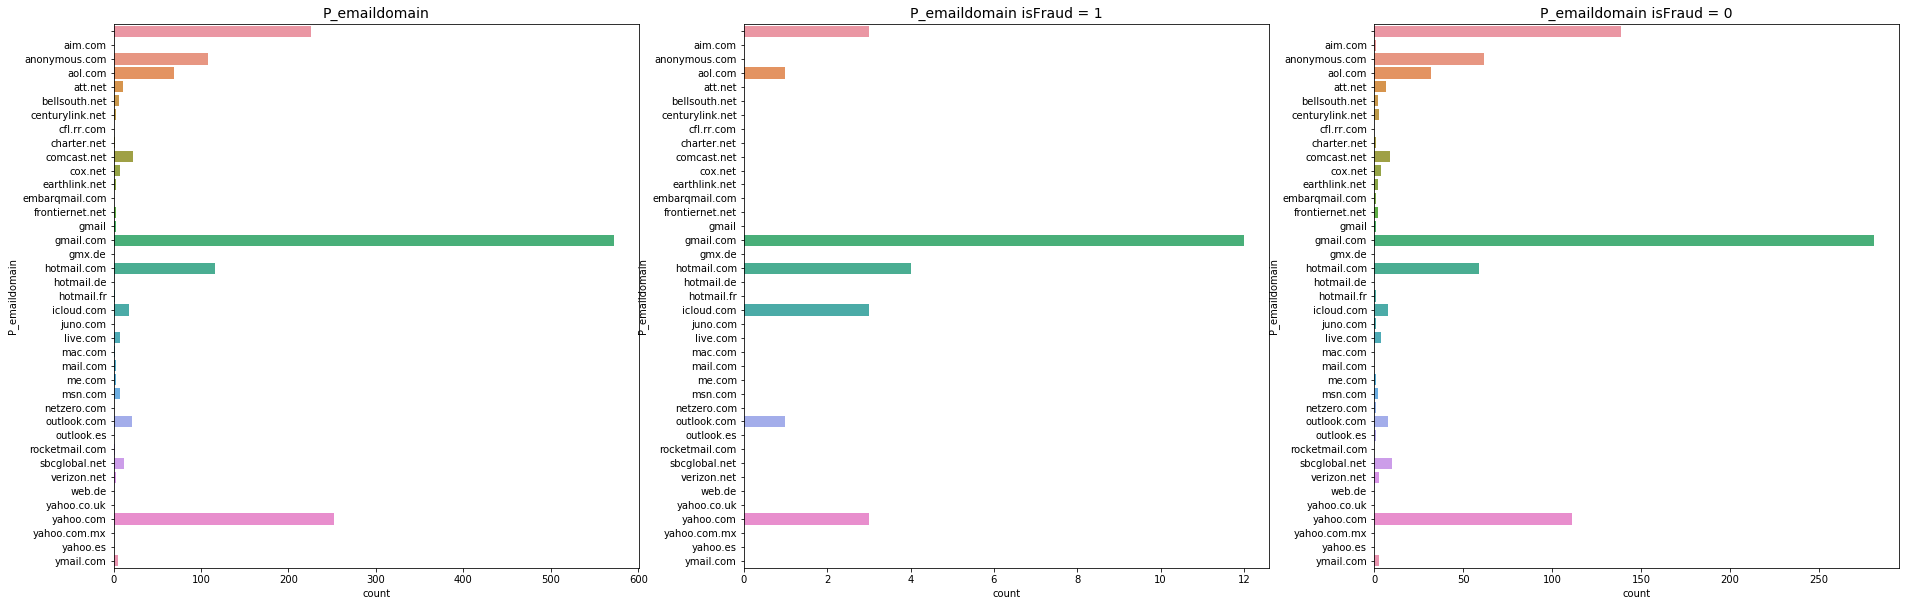

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(32,10))

sns.countplot(y="P_emaildomain", ax=ax[0], data=train_transaction)
ax[0].set_title('P_emaildomain', fontsize=14)
sns.countplot(y="P_emaildomain", ax=ax[1], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[1].set_title('P_emaildomain isFraud = 1', fontsize=14)
sns.countplot(y="P_emaildomain", ax=ax[2], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[2].set_title('P_emaildomain isFraud = 0', fontsize=14)
plt.show()

In [31]:
# Separate the domain and extension of the mails and create two different columns. FillNa.
df[['mail_domain','mail_extension']]=df['P_emaildomain'].str.split('.').apply(pd.Series).rename(columns={0:'mail_domain',1:'mail_extension'})[['mail_domain','mail_extension']].fillna('NoTiene')

***Kernel*** = https://www.kaggle.com/jazivxt/safe-box

***Discussion*** = https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654

I was going through Pemaildomain and Remaildomain and after some Googling and think the following domain names can be binned:

yahoo / ymail / frontier / rocketmail -> Yahoo

hotmail / outlook / live / msn -> Microsoft

icloud / mac / me -> Appe

prodigy / att / sbcglobal-> AT&T

centurylink / embarqmail / q -> Centurylink

aim / aol -> AOL

twc / charter -> Spectrum

I think the data predates the merger of AOL / Yahoo / Verizon, otherwise those three could be binned too.

In [32]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

In [33]:
labels = {np.nan: -999, 'nan': -999, 't': 1, 'f': 2, 'm2': 3, 'm0': 4, 'm1': 5, 'gmail.com': 6, 'outlook.com': 7, 'yahoo.com': 8, 'mail.com': 9, 'anonymous.com': 10, 'hotmail.com': 11, 'verizon.net': 12, 'aol.com': 13, 'me.com': 14, 'comcast.net': 15, 'optonline.net': 16, 'cox.net': 17, 'charter.net': 18, 'rocketmail.com': 19, 'prodigy.net.mx': 20, 'embarqmail.com': 21, 'icloud.com': 22, 'live.com.mx': 23, 'gmail': 24, 'live.com': 25, 'att.net': 26, 'juno.com': 27, 'ymail.com': 28, 'sbcglobal.net': 29, 'bellsouth.net': 30, 'msn.com': 31, 'q.com': 32, 'yahoo.com.mx': 33, 'centurylink.net': 34, 'servicios-ta.com': 35, 'earthlink.net': 36, 'hotmail.es': 37, 'cfl.rr.com': 38, 'roadrunner.com': 39, 'netzero.net': 40, 'gmx.de': 41, 'suddenlink.net': 42, 'frontiernet.net': 43, 'windstream.net': 44, 'frontier.com': 45, 'outlook.es': 46, 'mac.com': 47, 'netzero.com': 48, 'aim.com': 49, 'web.de': 50, 'twc.com': 51, 'cableone.net': 52, 'yahoo.fr': 53, 'yahoo.de': 54, 'yahoo.es': 55, 'sc.rr.com': 56, 'ptd.net': 57, 'live.fr': 58, 'yahoo.co.uk': 59, 'hotmail.fr': 60, 'hotmail.de': 61, 'hotmail.co.uk': 62, 'protonmail.com': 63, 'yahoo.co.jp': 64, 'scranton.edu': 65, 'w': 66, 'h': 67, 'c': 68, 's': 69, 'r': 70, 'discover': 71, 'mastercard': 72, 'visa': 73, 'american express': 74, 'credit': 75, 'debit': 76, 'debit or credit': 77, 'charge card': 78, 'notfound': 81, 'found': 82, 'new': 83, 'unknown': 84, 'ip_proxy:transparent': 85, 'ip_proxy:anonymous': 86, 'ip_proxy:hidden': 87, 'android 7.0': 88, 'ios 11.1.2': 89, 'mac os x 10_11_6': 90, 'windows 10': 91, 'android': 284, 'linux': 93, 'ios 11.0.3': 94, 'mac os x 10_7_5': 95, 'mac os x 10_12_6': 96, 'mac os x 10_13_1': 97, 'ios 11.1.0': 98, 'mac os x 10_9_5': 99, 'windows 7': 100, 'windows 8.1': 101, 'mac': 102, 'ios 10.3.3': 103, 'mac os x 10.12': 104, 'mac os x 10_10_5': 105, 'mac os x 10_11_5': 106, 'ios 9.3.5': 107, 'android 5.1.1': 108, 'android 7.1.1': 109, 'android 6.0': 110, 'ios 10.3.1': 111, 'mac os x 10.9': 112, 'ios 11.1.1': 113, 'windows vista': 114, 'ios 10.3.2': 115, 'ios 11.0.2': 116, 'mac os x 10.11': 117, 'android 8.0.0': 118, 'ios 10.2.0': 119, 'ios 10.2.1': 120, 'ios 11.0.0': 121, 'mac os x 10.10': 122, 'mac os x 10_12_3': 123, 'mac os x 10_12': 124, 'android 6.0.1': 125, 'ios': 126, 'mac os x 10.13': 127, 'mac os x 10_12_5': 128, 'mac os x 10_8_5': 129, 'ios 11.0.1': 130, 'ios 10.0.2': 131, 'android 5.0.2': 132, 'windows xp': 133, 'ios 11.2.0': 134, 'mac os x 10.6': 135, 'windows 8': 136, 'mac os x 10_6_8': 137, 'mac os x 10_11_4': 138, 'mac os x 10_12_1': 139, 'ios 10.1.1': 140, 'mac os x 10_11_3': 141, 'mac os x 10_12_4': 142, 'mac os x 10_13_2': 143, 'android 4.4.2': 144, 'mac os x 10_12_2': 145, 'android 5.0': 146, 'func': 147, 'android 7.1.2': 148, 'android 8.1.0': 149, 'other': 150, 'mac os x 10_13_3': 151, 'ios 11.2.1': 152, 'ios 11.2.5': 153, 'windows': 154, 'ios 11.2.2': 155, 'ios 11.3.0': 156, 'ios 11.2.6': 157, 'mac os x 10_13_4': 158, 'mac os x 10_13_5': 159, 'ios 11.4.0': 160, 'ios 11.3.1': 161, 'ios 11.4.1': 162, 'android 9': 163, 'ios 12.0.0': 164, 'mac os x 10_13_6': 165, 'mac os x 10.14': 166, 'mac os x 10_14_0': 167, 'mac os x 10_14': 168, 'ios 12.1.0': 169, 'mac os x 10_14_1': 170, 'ios 12.0.1': 171, 'ios 12.1.1': 172, 'mac os x 10_14_2': 173, 'ios 12.1.2': 174, 'samsung browser 6.2': 175, 'mobile safari 11.0': 176, 'chrome 62.0': 177, 'chrome 62.0 for android': 178, 'edge 15.0': 179, 'mobile safari generic': 180, 'chrome 49.0': 181, 'chrome 61.0': 182, 'edge 16.0': 183, 'safari generic': 184, 'edge 14.0': 185, 'chrome 56.0 for android': 186, 'firefox 57.0': 187, 'chrome 54.0 for android': 188, 'mobile safari uiwebview': 189, 'chrome': 190, 'chrome 62.0 for ios': 191, 'firefox': 192, 'chrome 60.0 for android': 193, 'mobile safari 10.0': 194, 'chrome 61.0 for android': 195, 'ie 11.0 for desktop': 196, 'ie 11.0 for tablet': 197, 'mobile safari 9.0': 198, 'chrome generic': 199, 'chrome 59.0 for android': 200, 'firefox 56.0': 201, 'android webview 4.0': 202, 'chrome 55.0': 203, 'opera 49.0': 204, 'ie': 205, 'chrome 55.0 for android': 206, 'firefox 52.0': 207, 'chrome 57.0 for android': 208, 'chrome 56.0': 209, 'chrome 46.0 for android': 210, 'chrome 58.0': 211, 'firefox 48.0': 212, 'chrome 59.0': 213, 'samsung browser 4.0': 214, 'edge 13.0': 215, 'chrome 53.0 for android': 216, 'chrome 58.0 for android': 217, 'chrome 60.0': 218, 'mobile safari 8.0': 219, 'firefox generic': 220, 'generic/android 7.0': 221, 'mobile': 222, 'samsung/sm-g532m': 223, 'chrome 50.0 for android': 224, 'chrome 51.0 for android': 225, 'chrome 63.0': 226, 'chrome 52.0 for android': 227, 'chrome 51.0': 228, 'firefox 55.0': 229, 'edge': 230, 'opera': 231, 'chrome generic for android': 232, 'aol': 233, 'samsung browser 5.4': 234, 'samsung/sch': 235, 'silk': 236, 'chrome 57.0': 237, 'firefox 47.0': 238, 'chrome 63.0 for android': 239, 'samsung/sm-g531h': 240, 'chrome 43.0 for android': 241, 'waterfox': 242, 'nokia/lumia': 243, 'chrome 63.0 for ios': 244, 'puffin': 245, 'microsoft/windows': 246, 'cyberfox': 247, 'generic/android': 248, 'samsung': 849, 'opera generic': 250, 'chrome 49.0 for android': 251, 'zte/blade': 252, 'safari': 253, 'android browser 4.0': 254, 'samsung browser 5.2': 255, 'palemoon': 256, 'maxthon': 257, 'line': 258, 'lg/k-200': 259, 'iron': 260, 'blu/dash': 261, 'seamonkey': 262, 'firefox 58.0': 263, 'chrome 64.0 for android': 264, 'chrome 64.0': 265, 'firefox 59.0': 266, 'chrome 64.0 for ios': 267, 'm4tel/m4': 268, 'comodo': 269, 'lanix/ilium': 270, 'samsung browser generic': 271, 'chromium': 272, 'opera 51.0': 273, 'inco/minion': 274, 'samsung browser 7.0': 275, 'mozilla/firefox': 276, 'samsung browser 4.2': 277, 'samsung browser 6.4': 278, 'chrome 65.0': 279, 'chrome 65.0 for android': 280, 'chrome 65.0 for ios': 281, 'cherry': 282, 'icedragon': 283, 'edge 17.0': 285, 'chrome 66.0': 286, 'chrome 66.0 for android': 287, 'safari 11.0': 288, 'safari 9.0': 289, 'safari 10.0': 290, 'google': 291, 'chrome 66.0 for ios': 292, 'google search application 48.0': 293, 'opera 52.0': 294, 'firefox 60.0': 295, 'opera 53.0': 296, 'samsung browser 3.3': 297, 'google search application 49.0': 298, 'facebook': 299, 'firefox mobile 61.0': 300, 'chrome 67.0': 301, 'chrome 69.0': 302, 'chrome 67.0 for android': 303, 'firefox 61.0': 304, 'samsung browser 7.2': 305, 'chrome 67.0 for ios': 306, 'google search application 52.0': 307, 'firefox 62.0': 308, 'mobile safari 12.0': 309, 'chrome 68.0': 310, 'opera 54.0': 311, 'firefox mobile 62.0': 312, 'google search application 54.0': 313, 'safari 12.0': 314, 'chrome 68.0 for android': 315, 'chrome 68.0 for ios': 316, 'chrome 39.0 for android': 317, 'chrome 70.0': 318, 'rim': 2752, 'chrome 69.0 for android': 320, 'google search application 56.0': 321, 'samsung browser 7.4': 322, 'opera 55.0': 323, 'firefox 63.0': 324, 'google search application 58.0': 325, 'chrome 69.0 for ios': 326, 'chrome 70.0 for android': 327, 'uc': 328, 'google search application 59.0': 329, 'opera 56.0': 330, 'chrome 71.0': 331, 'google search application 60.0': 332, 'edge 18.0': 333, 'chrome 70.0 for ios': 334, 'firefox mobile 63.0': 335, 'google search application 61.0': 336, 'firefox 64.0': 337, 'google search application 62.0': 338, 'chrome 71.0 for android': 339, 'google search application 63.0': 340, 'chrome 71.0 for ios': 341, 'google search application 64.0': 342, 'samsung browser 8.2': 343, 'google search application 65.0': 344, 'blackberry': 345, '2220x1080': 346, '1334x750': 347, '1280x800': 348, '1366x768': 349, '1920x1080': 350, '1680x1050': 351, '1136x640': 352, '5120x2880': 353, '2880x1800': 354, '1920x1200': 355, '2560x1600': 356, '2048x1536': 357, '1024x768': 358, '1280x720': 359, '2560x1440': 360, '2208x1242': 361, '2001x1125': 362, '1440x900': 363, '1600x900': 364, '2672x1440': 365, '1280x1024': 366, '960x540': 367, '2732x2048': 368, '2436x1125': 369, '2048x1152': 370, '2960x1440': 371, '1024x600': 372, '855x480': 373, '4096x2304': 374, '2160x1440': 375, '2562x1442': 376, '801x480': 377, '2736x1824': 378, '3441x1440': 379, '2880x1620': 380, '3840x2160': 381, '1638x922': 382, '1280x768': 383, '1360x768': 384, '1280x960': 385, '3440x1440': 386, '1152x720': 387, '1280x1025': 388, '3360x2100': 389, '2304x1296': 390, '1152x864': 391, '3200x1800': 392, '2112x1188': 393, '2224x1668': 394, '2400x1350': 395, '2000x1125': 396, '1600x1000': 397, '2560x1080': 398, '1728x972': 399, '3000x2000': 400, '1024x640': 401, '3840x2400': 402, '2304x1440': 403, '1280x600': 404, '1400x1050': 405, '1600x1200': 406, '3201x1800': 407, '1356x900': 408, '1344x756': 409, '1624x1080': 410, '1536x864': 411, '1800x1125': 412, '1920x1281': 413, '2961x1442': 414, '1366x1024': 415, '1344x840': 416, '3360x1890': 417, '1536x1152': 418, '1200x675': 419, '1480x720': 420, '2400x1600': 421, '3200x2000': 422, '1281x801': 423, '960x640': 424, '1776x1000': 425, '2048x1280': 426, '2049x1152': 427, '1138x640': 428, '2160x1215': 429, '2880x1440': 430, '0x0': 431, '2520x1575': 432, '5760x3240': 433, '3843x2163': 434, '1184x720': 435, '1440x810': 436, '2076x1080': 437, '1600x837': 438, '1093x615': 439, '1281x721': 440, '1152x648': 441, '2392x1440': 442, '2048x1080': 443, '2735x1825': 444, '1680x945': 445, '1805x1015': 446, '5760x1080': 447, '2816x1584': 448, '4500x3000': 449, '1684x947': 450, '1440x960': 451, '1364x768': 452, '3072x1728': 453, '5040x3150': 454, '7500x5000': 455, '768x576': 456, '1768x992': 457, '1658x946': 458, '1200x720': 459, '1239x697': 460, '1188x720': 461, '1232x800': 462, '1920x1280': 463, '1264x924': 464, '1400x900': 465, '3240x2160': 466, '2961x1440': 467, '1422x889': 468, '1848x1155': 469, '3360x1050': 470, '3840x1080': 471, '2010x1080': 472, '2160x1350': 473, '1440x720': 474, '1280x712': 475, '1512x945': 476, '1296x774': 477, '1368x768': 478, '3520x1980': 479, '800x600': 480, '1700x960': 481, '2560x1800': 482, '6400x3600': 483, '2368x1440': 484, '1824x1026': 485, '1912x1025': 486, '600x450': 487, '3840x1600': 488, '1760x990': 489, '2700x1800': 490, '1371x857': 491, '1776x1080': 492, '2552x1337': 493, '3600x2250': 494, '2560x1700': 495, '2816x1760': 496, '1440x800': 497, '1440x803': 498, '1920x1018': 499, '6016x3384': 500, '1280x620': 501, '1281x720': 502, '1720x1440': 503, '1408x880': 504, '640x360': 505, '1920x975': 506, '976x600': 507, '1062x630': 508, '2800x1575': 509, '6720x3780': 510, '1440x759': 511, '1120x700': 512, '1921x1081': 513, '1280x1023': 514, '1279x1023': 515, '1441x901': 516, '1679x1049': 517, '1680x1051': 518, '2220x1081': 519, '1920x1079': 520, '1919x1199': 521, '1680x1049': 522, '1365x768': 523, '1919x1079': 524, '1919x1200': 525, '1919x1080': 526, '1366x767': 527, '1584x990': 528, '2880x1442': 529, '1281x800': 530, '1229x691': 531, '1600x1024': 532, '1600x899': 533, '1536x960': 534, '1502x844': 535, '1920x1201': 536, '1439x809': 537, '1408x792': 538, '1279x1024': 539, '1599x900': 540, '1920x1081': 541, '921x691': 542, '3841x2161': 543, '1921x1080': 544, '480x320': 545, '1888x941': 546, '2049x1536': 547, '2160x1439': 548, '1707x960': 549, '1024x767': 550, '1365x767': 551, '3001x2000': 552, '3839x2160': 553, '1916x901': 554, '3838x2158': 555, '1599x899': 556, '3199x1800': 557, '1511x944': 558, '2737x1825': 559, '2736x1823': 560, '2735x1823': 561, '2559x1439': 562, '2400x1500': 563, '2882x1442': 564, '1729x973': 565, '1727x971': 566, '1023x767': 567, '1918x1080': 568, '1439x900': 569, '4499x2999': 570, '1280x740': 571, '2999x2000': 572, '1024x552': 573, '1440x899': 574, '2255x1503': 575, '1025x768': 576, '1280x732': 577, '3839x2159': 578, '3840x2162': 579, '3696x2310': 580, '2159x1439': 581, '2256x1504': 582, '1439x899': 583, '2159x1440': 584, '1359x768': 585, '1092x614': 586, '2048x1278': 587, '2591x1619': 588, '4200x2625': 589, '2710x1440': 590, '1272x960': 591, '1023x768': 592, '3838x2160': 593, '2100x1312': 594, '1360x767': 595, '1024x819': 596, '1502x845': 597, '2561x1442': 598, '2559x1440': 599, '2160x1081': 600, '1920x1279': 601, '2160x1080': 602, '1596x710': 603, '1496x844': 604, '1280x900': 605, '2047x1152': 606, '2094x1080': 607, '1800x1440': 608, '993x664': 609, '1622x1081': 610, '1360x765': 611, '1280x799': 612, '1279x800': 613, '1920x983': 614, '888x540': 615, '1722x1440': 616, '1679x1050': 617, '2791x1440': 618, '1921x1200': 619, '6144x3456': 620, '2699x1799': 621, '4096x3072': 622, '4608x2592': 623, '910x512': 624, '2257x1505': 625, '1536x1024': 626, '1208x720': 627, '1842x1047': 628, '2462x1641': 629, '1920x1199': 630, '1601x900': 631, '1368x912': 632, '2112x1320': 633, '1265x948': 634, '1359x767': 635, '1920x1017': 636, '1681x1050': 637, '3241x2161': 638, '3011x2007': 639, '2188x1459': 640, '1599x1200': 641, '1500x1000': 642, '2560x1313': 643, '1920x1440': 644, '2703x1441': 645, '1151x921': 646, '3000x1687': 647, '1151x863': 648, '1480x721': 649, '792x480': 650, '3521x1980': 651, '1279x767': 652, '3200x1801': 653, '2560x1439': 654, '1272x952': 655, '1600x901': 656, '2255x1504': 657, '1862x1048': 658, '3840x2159': 659, '3168x1980': 660, '3439x1440': 661, '2560x1441': 662, '800x480': 663, '3200x1799': 664, '3840x2161': 665, '1364x767': 666, '3000x1999': 667, '2688x1242': 668, '1080x675': 669, '2735x1824': 670, '2303x1295': 671, '1592x828': 672, '3122x1442': 673, '2560x1599': 674, '3239x2159': 675, '1281x1024': 676, '1466x403': 677, '4096x2160': 678, '1727x1079': 679, '1231x358': 680, '3584x2016': 681, '2390x1344': 682, '3839x2158': 683, '2281x1081': 684, '1152x672': 685, '2401x1350': 686, '2560x1079': 687, '2161x1080': 688, '1366x766': 689, '683x384': 690, '1720x947': 691, '1024x576': 692, '4320x2700': 693, '2341x1081': 694, '1537x865': 695, '1792x828': 696, '960x480': 697, '3280x2048': 698, '1408x844': 699, '1021x669': 700, '1800x1200': 701, '3120x1440': 702, '1919x1279': 703, '1279x799': 704, '2556x1248': 705, '1000x798': 706, '1600x1280': 707, '1296x810': 708, '3199x1799': 709, '2562x1314': 710, '1624x750': 711, '1416x805': 712, '1920x1128': 713, '2399x1598': 714, '3840x1599': 715, '1918x1078': 716, '2388x1668': 717, '2592x1728': 718, '2562x1441': 719, '1792x768': 720, '3201x1799': 721, '1679x987': 722, '3841x2401': 723, '1794x1080': 724, '1279x720': 725, '2960x1442': 726, '1501x844': 727, '1918x1347': 728, '2950x1440': 729, '1024x820': 730, '1366x769': 731, '2401x1351': 732, '1600x868': 733, '1280x801': 734, '1264x945': 735, '1279x719': 736, '4800x2700': 737, '1151x864': 738, '2880x1920': 739, '960x600': 740, '2696x1440': 741, '5960x1080': 742, '2241x1081': 743, '7680x4320': 744, '2303x1439': 745, '1025x640': 746, '2399x1348': 747, '8640x1620': 748, '2048x1151': 749, '1399x1050': 750, '1920x974': 751, '4225x2377': 752, '2680x1440': 753, '1223x691': 754, '2047x1279': 755, '1279x768': 756, '1621x1081': 757, '1152x922': 758, '1260x787': 759, '1669x942': 760, '3123x1440': 761, '2463x1642': 762, '1361x768': 763, '2048x1537': 764, '8960x5040': 765, '1500x840': 766, '2559x1080': 767, '1408x1127': 768, '1416x758': 769, '2560x1418': 770, '1926x921': 771, '1268x862': 772, '3784x1584': 773, '4500x3001': 774, '2398x1599': 775, '1344x720': 776, '2559x1599': 777, '2133x1080': 778, '1919x1280': 779, '2340x1080': 780, '2999x1998': 781, '1151x719': 782, '2160x1920': 783, '2052x1368': 784, '4300x1800': 785, '1501x843': 786, '2559x1079': 787, '1281x769': 788, '1408x1126': 789, '1680x1018': 790, '2162x1081': 791, '455x256': 792, '2646x1440': 793, '2562x1440': 794, '2789x1442': 795, '2241x1080': 796, '3839x1599': 797, '1280x767': 798, '2561x1312': 799, '2162x1082': 800, '2768x1440': 801, '3239x2160': 802, '2341x1080': 803, '2928x1440': 804, '1767x991': 805, '2734x1824': 806, 'match_status:2': 807, 'match_status:1': 808, 'match_status:0': 809, 'match_status:-1': 810, 'desktop': 811, 'samsung sm-g892a build/nrd90m': 812, 'ios device': 813, 'macos': 814, 'sm-g930v build/nrd90m': 815, 'blade a602 build/mra58k': 816, 'xt1635-02 build/npn26.118-22-2': 817, 'z970': 818, 'sm-n920v build/nrd90m': 819, 'redmi note 4 build/mmb29m': 820, 'lenovo pb1-750m build/s100': 821, 'lt22i build/6.2.a.1.100': 822, 'rv:52.0': 823, 'sm-g950u build/nrd90m': 824, 'lg-h872 build/nrd90u': 825, 'lg-k500 build/mmb29m': 826, 'sm-p550 build/mmb29m': 827, 'sm-j700m build/mmb29k': 828, 'trident/7.0': 829, 'rv:57.0': 830, 'samsung sm-g930t build/nrd90m': 831, 'blade v6 plus build/mra58k': 832, 'bll-l23 build/huaweibll-l23': 833, 'kyocera-c6742a build/lmy47v': 834, 'f3113 build/33.2.a.4.70': 835, 'd5306 build/19.4.a.0.182': 836, 'm4 ss4457 build/mra58k': 837, 'sm-g955u build/nrd90m': 838, 'sm-g610m build/mmb29k': 839, 'samsung sm-g935f build/nrd90m': 840, 'xt1635-01': 841, 'rv:56.0': 842, 'vs500': 843, 'cam-l03 build/huaweicam-l03': 844, 'rct6303w87m7 build/mra58k': 845, 'm4 ss4451 build/lmy47d': 846, 'kffowi build/lvy48f': 847, 'moto e (4) build/nma26.42-19': 848, 'e2306 build/26.3.a.1.33': 850, 'ilium l910 build/mra58k': 851, 'gt-i9300': 852, 'lg-h420 build/lrx21y': 853, 'windows nt 6.2': 854, 'xt1032 build/lpbs23.13-56-2': 855, 'gt-i9060m build/ktu84p': 856, 'rv:38.0': 857, 'moto g (4) build/npjs25.93-14-10': 858, 'sm-g530t': 859, 'lgmp260 build/nrd90u': 860, 'sm-e500m build/ktu84p': 861, 'samsung sm-g950u build/nrd90m': 862, 'rv:11.0': 863, 'sm-g920i build/nrd90m': 864, 'samsung sm-j327t build/nrd90m': 865, 'sm-g900h build/mmb29k': 866, 'trt-l53 build/huaweitrt-l53': 867, 'moto g play build/mpis24.241-15.3-26': 868, 'nexus 6p build/opr5.170623.011': 869, 'sgp521': 870, 'vs988 build/nrd90u': 871, 'sm-g531h build/lmy48b': 872, 'moto c build/nrd90m.063': 873, 'lg-k410 build/lrx22g': 874, 'sm-g935f build/mmb29k': 875, 'moto c plus build/nrd90m.05.022': 876, 'lg-x180g build/lmy47i': 877, 'sm-g925p build/nrd90m': 878, 'es-us': 879, 'sm-g920v build/nrd90m': 880, 'sm-g935t build/nrd90m': 881, 'moto e (4) plus build/nma26.42-69': 882, 'sm-g925w8': 883, 'rv:48.0': 884, 'samsung-sm-g930a build/nrd90m': 885, 'htc one m9 build/nrd90m': 886, '7055a build/kvt49l': 887, 'moto g play build/mpis24.241-15.3-7': 888, 'sm-t810 build/nrd90m': 889, 'rv:51.0': 890, 'sm-n910v build/mmb29m': 891, 'sm-g930t build/nrd90m': 892, 'lg-h870 build/nrd90u': 893, 'samsung sm-g950u1 build/nrd90m': 894, 'samsung sm-s727vl build/mmb29m': 895, 'sm-n920g build/nrd90m': 896, 'moto g (5) plus build/npn25.137-72': 897, 'moto g (5) build/npp25.137-72': 898, 'sm-g935f build/nrd90m': 899, 'lg-d373 build/kot49i.v10a': 900, 'ale-l23 build/huaweiale-l23': 901, 'z836bl': 902, 'ilium x710 build/mra58k': 903, 'lg-d680 build/kot49i': 904, 'm4 ss4450 build/mra58k': 905, 'lg-k580 build/mra58k': 906, 'sm-j700m build/lmy48b': 907, 'sm-a710m': 908, 'moto z2 play build/npss26.118-19-6': 909, 'moto g (4) build/npj25.93-14.5': 910, 'z981 build/mmb29m': 911, 'sm-t710 build/nrd90m': 912, 'sm-t700 build/mmb29k': 913, 'one touch 4033a build/jdq39': 914, 'f5121 build/34.3.a.0.228': 915, 'was-lx3 build/huaweiwas-lx3': 916, 'r8106': 917, 'motog3 build/mpis24.65-33.1-2-16': 918, 'sm-g925i build/mmb29k': 919, 'huawei vns-l53 build/huaweivns-l53': 920, 'blade v6 build/lrx22g': 921, 'sm-t113nu build/ktu84p': 922, 'samsung sm-g530h build/lrx22g': 923, 'sm-j510mn build/mmb29m': 924, 'sm-g950f build/nrd90m': 925, 'samsung sm-j700m build/mmb29k': 926, 'sm-g570m build/mmb29k': 927, 'samsung-sm-g891a build/nrd90m': 928, 'sm-j500m build/lmy48b': 929, 'sm-j727u build/nrd90m': 930, 'lgls676 build/mxb48t': 931, 'ta-1003': 932, 'sm-g900v build/mmb29m': 933, 'vk810': 934, 'kfaswi build/lvy48f': 935, 'sm-j320m build/lmy47v': 936, 'sm-j120h build/lmy47v': 937, 'sm-n950u build/nmf26x': 938, 'lg-d693n build/lrx22g': 939, 'huawei rio-l03 build/huaweirio-l03': 940, 'samsung sm-g930a build/nrd90m': 941, '5012g build/mra58k': 942, 'sm-p350 build/mmb29m': 943, 'sm-a300h build/lrx22g': 944, 'moto': 1166, 'sm-g925v build/nrd90m': 946, 'samsung sm-n910a build/mmb29m': 947, 'sm-g532m build/mmb29t': 948, '5080a build/mra58k': 949, 'xt1254 build/mcg24.251-5-5': 950, 'kfgiwi build/lvy48f': 951, 'lg-d331 build/lrx22g': 952, 'sm-g950u1 build/nrd90m': 953, 'pixel': 954, 'sm-g900t build/mmb29m': 955, 'e5606 build/30.2.a.1.21': 956, 'moto z2 play build/nps26.74-16-1': 957, 'z410': 958, 'lg-h500 build/lrx21y': 959, 'huawei tag-l13 build/huaweitag-l13': 960, 'p4526a build/nrd90m': 961, 'sm-g900f build/mmb29m': 962, 'moto g (4) build/npj25.93-14.7': 963, 'sm-a510m build/nrd90m': 964, 'xt1565': 965, 'blade v6 max build/mra58k': 966, 'f3213 build/36.1.a.1.86': 967, 'rex': 968, 'pixel build/opr3.170623.013': 969, 'xt1585 build/nck25.118-10.5': 970, 'motog3-te': 971, 'ilium lt510 build/mra58k': 972, 'samsung-sm-g870a build/mmb29m': 973, 'sm-a500m build/ktu84p': 974, 'htc': 975, 'samsung sm-g950f build/nrd90m': 976, 'lg-x240 build/mra58k': 977, 'kfauwi build/lvy48f': 978, 'lg-k428 build/mmb29m': 979, 'samsung sm-t580 build/nrd90m': 980, 'edison': 981, 'hisense f20 build/mmb29m': 982, 'sm-j327v build/nrd90m': 983, 'lgls775 build/nrd90u': 984, 'sm-a710m build/lmy47x': 985, 'lg-ls777 build/nrd90u': 986, 'lg-h320 build/lrx21y': 987, 'qtasun1 build/nrd90m': 988, 'sm-j730g build/nrd90m': 989, 'rv:58.0': 990, 'htc 10 build/nrd90m': 991, 'xt1063': 992, 'vs995 build/nrd90m': 993, 'sm-g550t build/mmb29k': 994, 'samsung sm-g930p build/nrd90m': 995, 'lg-k530 build/mmb29m': 996, 'samsung sm-j701m build/nrd90m': 997, 'samsung sm-t587p build/nrd90m': 998, 'sm-t530nu build/lrx22g': 999, 'sm-s920l': 1000, 'sm-g530h build/lrx22g': 1001, 'lg-v410': 1002, 'samsung sm-g891a build/nrd90m': 1003, 'gt-p5113': 1004, 'lg-h840 build/nrd90u': 1005, 'bac-l03 build/huaweibac-l03': 1006, 'samsung sm-t810 build/nrd90m': 1007, 'vs835': 1008, 'lg-tp450 build/nrd90u': 1009, 'sm-j727v build/nrd90m': 1010, 'sm-g955f build/nrd90m': 1011, 'kfdowi build/lvy48f': 1012, 'sm-j200m build/lmy47x': 1013, 'sm-j320h': 1014, 'blade v8 se build/nrd90m': 1015, 'sm-n920t build/nrd90m': 1016, 'lg-h542 build/mra58k': 1017, 'sm-t330nu build/lmy47x': 1018, 'samsung sm-j500m build/lmy48b': 1019, 'lg-m322': 1020, 'chc-u03 build/huaweichc-u03': 1021, 'htc desire 650 build/mmb29m': 1022, 'samsung-sm-g935a build/nrd90m': 1023, 'sm-g925i build/nrd90m': 1024, 'lg-k200 build/mxb48t': 1025, 'aquaris': 1026, 'sm-j710mn build/mmb29k': 1027, 'alcatel_4060a': 1028, 'lgms631 build/mra58k': 1029, 'mot-a6020l37 build/lmy47v': 1030, '5011a build/nrd90m': 1031, 'sm-t550 build/nmf26x': 1032, 'moto g (5) plus build/npns25.137-15-11': 1033, 'e6603 build/32.4.a.1.54': 1034, 'redmi 4a build/mmb29m': 1035, 'rv:55.0': 1036, 'sm-t520': 1037, 'htc desire 10 lifestyle build/mmb29m': 1038, 'sm-a720f build/mmb29k': 1039, 'moto g (5s': 1040, 'sm-g925i build/lmy47x': 1041, 'sm-g930r4 build/nrd90m': 1042, 'samsung sm-g610m build/mmb29k': 1043, 'lenovo k33b36 build/nrd90n': 1044, 'sm-g930u build/nrd90m': 1045, 'moto z2 play build/nps26.118-19': 1046, 'samsung sm-n950u build/nmf26x': 1047, 'sm-a320fl build/mmb29k': 1048, 'lg-m250 build/nrd90u': 1049, 'kfsawi': 1050, 'samsung sm-g930f build/nrd90m': 1051, 'lenovo k33b36 build/mmb29m': 1052, 'samsung sm-n920v build/nrd90m': 1053, 'windows nt 6.1': 1054, 'rv:45.0': 1055, 'samsung-sm-j327a build/nrd90m': 1056, 'sm-g935v build/nrd90m': 1057, 'mddrjs': 1058, 'sm-g935p build/nrd90m': 1059, 'sm-g930p build/nrd90m': 1060, 'sm-g928v build/nrd90m': 1061, 'lg-m210 build/nrd90u': 1062, 'blade v580 build/lmy47d': 1063, 'ilium lt500 build/lmy47o': 1064, 'y635-l03 build/huaweiy635-l03': 1065, 'xt1635-01 build/ndns26.118-23-12-3': 1066, 'rv:42.0': 1067, 'samsung sm-g925t build/nrd90m': 1068, 'samsung-sm-g900a build/lrx21t': 1069, 'moto z (2': 1070, 'sm-g360t1 build/lmy47x': 1071, 'sm-s903vl': 1072, 'samsung sm-g920a build/nrd90m': 1073, 'huawei vns-l23 build/huaweivns-l23': 1074, 'lg-h811 build/mra58k': 1075, 'm4 ss4456 build/lmy47v': 1076, 'samsung-sm-t337a build/lmy47x': 1077, 'samsung sm-g955u build/nrd90m': 1078, 'sm-g900p build/mmb29m': 1079, 'sm-g800f build/kot49h': 1080, 'bntv400': 1081, 'huawei vns-l21 build/huaweivns-l21': 1082, 'oneplus a5000 build/nmf26x': 1083, 'htc desire 626s build/lmy47o': 1084, 'xt1710-02 build/ndss26.118-23-15': 1085, 'rv:49.0': 1086, 'eva-l09 build/huaweieva-l09': 1087, 'lenovo': 1088, 'lg-k540 build/mmb29m': 1089, 'frd-l04 build/huaweifrd-l04': 1090, 'linux x86_64': 1091, 'samsung sm-g935t build/nrd90m': 1092, 'sm-g900m build/lrx21t': 1093, 'lg-h820 build/nrd90u': 1094, 'z983 build/nmf26f': 1095, 'lgls991': 1096, 'sm-s120vl': 1097, 'le': 1098, 'ilium l1120 build/nrd90m': 1099, 'xt1650 build/ncls26.118-23-13-3': 1100, 'sm-t377p build/nmf26x': 1101, 'qtaqz3 build/lmy47v': 1102, 'sm-a310m': 1103, 'f5321': 1104, 'kftbwi build/lvy48f': 1105, 'm4 ss4453 build/mmb29m': 1106, 'xt1064 build/mpb24.65-34-3': 1107, 'vs987 build/nrd90u': 1108, 'sm-g386t': 1109, 'samsung-sm-n920a build/nrd90m': 1110, 'samsung sm-j727t1 build/nrd90m': 1111, 'samsung sm-g532m build/mmb29t': 1112, 'sm-g925t build/nrd90m': 1113, 'nethelper70': 1114, 'samsung sm-g890a build/nrd90m': 1115, 'd5803 build/23.5.a.1.291': 1116, 'gt-i8190l build/jzo54k': 1117, 'sm-a510m build/lmy47x': 1118, 'nexus': 1119, 'sm-t580 build/nrd90m': 1120, 'sm-g900v': 1121, 'zeia8': 1122, 'sm-n920p build/nrd90m': 1123, 'sm-t550': 1124, 'samsung sm-j320f build/lmy47v': 1125, 'vs501 build/nrd90u': 1126, 'linux i686': 1127, 'sm-g900p build/lrx21t': 1128, 'sm-n910h': 1129, 'sm-g920f build/nrd90m': 1130, 'sm-t560 build/ktu84p': 1131, 'motoe2(4g-lte': 1132, 'lg-h542 build/lrx22g': 1133, 'touch': 1134, 'moto g (5) build/npp25.137-82': 1135, 'lg-x230 build/mra58k': 1136, 'lg-k371': 1137, 'f3113 build/33.3.a.1.97': 1138, 'sm-t560nu build/mmb29m': 1139, 'samsung sm-a520f build/nrd90m': 1140, 'sm-p600 build/lmy47x': 1141, 'htc u11 build/nmf26x': 1142, 'kfapwi build/ktu84m': 1143, 'g3313': 1144, 'ax920': 1145, 'sm-j327vpp build/nrd90m': 1146, 'lg-m320 build/nrd90u': 1147, 'sm-g610f': 1148, 'rv:54.0': 1149, 'qmv7a': 1150, 'sm-t817v build/nrd90m': 1151, 'htc desire 530 build/mmb29m': 1152, 'lg-ls998': 1153, 'rv:41.0': 1154, 'gt-p5210 build/jdq39': 1155, 'sm-j730f': 1156, 'kfjwi': 1157, 'moto g (5) plus build/npn25.137-83': 1158, 'htc desire 510 build/kot49h': 1159, 'lg-h810': 1160, 'sm-g920p build/nrd90m': 1161, 'd6603 build/23.5.a.1.291': 1162, 'xt1650': 1163, 'sm-g930f build/nrd90m': 1164, 'lgms550 build/nrd90u': 1165, 'sm-a520f build/nrd90m': 1167, 'sm-g920t build/nrd90m': 1168, 'fractal': 1169, 'moto e (4) build/nma26.42-69': 1170, 'huawei': 1171, 'sm-t350 build/nmf26x': 1172, 'samsung sm-j730gm build/nrd90m': 1173, 'ta-1039 build/n2g47h': 1174, 'xt1003': 1175, 'motog3 build/mpis24.65-25.1-19': 1176, 'bv6000': 1177, 'sm-t230 build/kot49h': 1178, 'samsung sm-g920p build/nrd90m': 1179, 'htc one a9 build/nrd90m': 1180, 'nx785qc8g': 1181, 'rv:47.0': 1182, 'e5506 build/29.1.a.0.101': 1183, 'lgl33l/v100': 1184, 'sm-g920v build/mmb29k': 1185, 'sm-j510fn': 1186, 'lgms330 build/lmy47v': 1187, 'microsoft': 1188, 'sm-t560nu build/nmf26x': 1189, 'samsung sm-g955f build/nrd90m': 1190, 'xt1053 build/lpas23.12-21.7-1': 1191, '5025g build/lmy47i': 1192, 'lg-h918 build/nrd90m': 1193, 'sm-g900w8': 1194, 'sm-j320v build/nmf26x': 1195, 'sm-j105b build/lmy47v': 1196, 'samsung sm-g550t1 build/mmb29k': 1197, '5010s build/mra58k': 1198, 'lg-h910 build/nrd90m': 1199, 'motoe2 build/lpcs23.13-56-5': 1200, 'lgms210 build/nrd90u': 1201, 'lg-m700 build/nmf26x': 1202, 'sm-g930v build/mmb29m': 1203, 'sm-a510m build/mmb29k': 1204, '5054n': 1205, 'samsung sm-g900a build/mmb29m': 1206, 'sm-g935v': 1207, 'samsung-sm-t677a': 1208, 'sm-j500fn': 1209, 'lgmp450 build/nrd90u': 1210, 'pixel 2 build/opm1.171019.011': 1211, 'sm-j701m build/nrd90m': 1212, 'z798bl build/mmb29m': 1213, 'huawei cun-l03 build/huaweicun-l03': 1214, 'lenovo-a6020l36 build/lmy47v': 1215, 'vs820': 1216, 'kfthwi build/ktu84m': 1217, 'lg-k530 build/nrd90u': 1218, 'sm-t827v build/nrd90m': 1219, 'samsung sm-g935f build/mmb29k': 1220, 'lg-h650 build/mra58k': 1221, 'samsung-sgh-i337 build/kot49h': 1222, 'lg-k220 build/mxb48t': 1223, 'lg-h810/h81021z': 1224, 'ale-l21 build/huaweiale-l21': 1225, 'redmi 4x build/n2g47h': 1226, 'samsung sm-g935a build/nrd90m': 1227, 'sm-t713 build/nrd90m': 1228, '5051a build/mmb29m': 1229, 'lg-p714': 1230, 'samsung sm-g531h build/lmy48b': 1231, 'sm-g928g build/nrd90m': 1232, 'x10': 1233, 'gt-p5210 build/kot49h': 1234, 'gt-i9500': 1235, 'huawei y625-u13 build/huaweiy625-u13': 1236, 'hisense l675 build/mra58k': 1237, 'p5526a build/nrd90m': 1238, 'sm-t818v': 1239, 'es-mx': 1240, 'ta-1039 build/nmf26f': 1241, 'sm-a310m build/lmy47x': 1242, 'lg-d851': 1243, 'sm-j320v build/mmb29m': 1244, 'lg-h990 build/nrd90m': 1245, 'lg-v495/v49520l': 1246, 'sm-t350 build/mmb29m': 1247, 'pra-lx3 build/huaweipra-lx3': 1248, 'xt1080 build/su6-7.7': 1249, 'huawei y520-u03 build/huaweiy520-u03': 1250, 'lenovo a2016b30 build/mra58k': 1251, 'mya-l23': 1252, 'k88 build/mmb29m': 1253, 'motog3 build/mpis24.107-55-2-17': 1254, 'lgls770': 1255, 'lg-m153 build/mxb48t': 1256, 'qtair7 build/lmy47d': 1257, '2pq93': 1258, 'sm-j111m build/lmy47v': 1259, 'sm-s320vl': 1260, 'lg-h901': 1261, 'ilium': 1831, 'sm-t377v build/nmf26x': 1263, 'one a2005 build/mmb29m': 1264, 'sm-n910t build/mmb29m': 1265, 'android 5.1': 1266, 'xt1058 build/lpas23.12-21.7-1': 1267, 'pixel build/opm1.171019.011': 1268, 'pixel xl build/opm1.171019.011': 1269, 'lg-tp260 build/nrd90u': 1270, 'sm-n900v build/lrx21v': 1271, 'moto x play build/npd26.48-24-1': 1272, 'sky_5.0lm': 1273, 'sm-a320y build/nrd90m': 1274, 'sm-t230nu build/kot49h': 1275, 'kftt build/iml74k': 1276, '2ps64 build/nrd90m': 1277, 'samsung-sm-g930a': 1278, 'stv100-2 build/mmb29m': 1279, 'g3123 build/40.0.a.6.135': 1280, 'samsung sm-a300h build/lrx22g': 1281, 'z971': 1282, 'sm-g935w8': 1283, 'sm-p580 build/nrd90m': 1284, 'samsung-sm-j320a build/mmb29k': 1285, 'samsung-sm-j727a build/nrd90m': 1286, 'verykools5030': 1287, 'sm-j320p build/lmy47x': 1288, 'lgls751': 1289, 'f8331 build/41.2.a.7.76': 1290, 'sm-a520f build/mmb29k': 1291, 'blade l5 build/lmy47i': 1292, 'tommy2': 1293, 'rv:50.0': 1294, 'sla-l03 build/huaweisla-l03': 1295, 'moto e (4) build/nma26.42-11-3': 1296, 'sm-t280 build/lmy47v': 1297, 'f8331': 1298, 'z837vl': 1299, 'sm-a510f build/nrd90m': 1300, 'xt1580': 1301, 'sm-t820 build/nrd90m': 1302, 'sm-g550t1 build/mmb29k': 1303, 'lg-h871': 1304, 'lg-ls993 build/nrd90u': 1305, 'sm-t377w': 1306, 'samsung sm-j700m build/lmy48b': 1307, 'sm-g900f build/lrx21t': 1308, 'samsung-sm-g900a build/mmb29m': 1309, 'xt1032 build/kxb21.14-l1.40': 1310, 'xt1563 build/mpds24.107-52-5': 1311, 'blade': 3252, 'verykools5019': 1313, 'sm-g360v build/lmy48b': 1314, 'lg-x210 build/lmy47i': 1315, 'hi6210sft build/mra58k': 1316, 'samsung sm-t530nu build/lrx22g': 1317, 'c6743 build/lmy47v': 1318, 'bln-l24 build/honorbln-l24': 1319, 'sm-g935t': 1320, 'redmi note 3 build/mmb29m': 1321, 'samsung-sm-g900a build/lmy47x': 1322, 'e6810 build/5.320vz.03.r': 1323, 'e6553': 1324, 'pixel 2 xl build/opm1.171019.011': 1325, 'z835 build/nmf26v': 1326, 'lg-d725': 1327, 'xt1008 build/lpbs23.13-56-2': 1328, 'xt1040': 1329, 'en-us': 1330, 'sm-t807v': 1331, 'vs996': 1332, 'e6853': 1333, 'lg-k550 build/nrd90u': 1334, 'xt1030 build/su6-7.7': 1335, 'lg-m154': 1336, 'sm-j700t build/nmf26x': 1337, 'sm-g920f build/mmb29k': 1338, '8050g build/lmy47i': 1339, 'sm-a500fu build/mmb29m': 1340, 'sm-t337v': 1341, 'samsung-sm-t377a build/mmb29k': 1342, 'helio': 1343, 'blade v7 build/mra58k': 1344, 'motog3 build/mpi24.65-33.1-2': 1345, 'sm-n950f build/nmf26x': 1346, 'lgms550 build/mxb48t': 1347, 'xt1031': 1348, 'samsung sm-t710 build/nrd90m': 1349, 'lenovo tb-7703x build/s100': 1350, 'moto g (5) build/npps25.137-15-11': 1351, 'lt30p': 1352, 'moto g (4) build/npj25.93-14': 1353, 'mha-l09 build/huaweimha-l09': 1354, 'huawei vns-l31 build/huaweivns-l31': 1355, 'hisense l675 pro build/nrd90m': 1356, 'samsung-sm-g925a build/nrd90m': 1357, 'mi a1 build/n2g47h': 1358, 'sm-n900t': 1359, 'vs425pp build/lmy47v': 1360, 'sm-j727t build/nrd90m': 1361, 'lg-x220 build/lmy47i': 1362, 'att-ie11': 1363, 'samsung sm-g900f build/mmb29m': 1364, 'blade v8 build/nrd90m': 1365, 'sm-j700t1 build/nmf26x': 1366, 'sm-g930r7': 1367, 'lgus215 build/nrd90u': 1368, 'sm-t237p': 1369, 'ta-1038': 1370, 'sm-g930w8 build/nrd90m': 1371, 'sm-g950w': 1372, 'sm-j100vpp build/lmy48b': 1373, 'lgls990': 1374, 'sm-a500h': 1375, 'f3313 build/37.0.a.2.108': 1376, 'sm-g900i': 1377, 'sm-t813 build/nrd90m': 1378, 'rv:31.0': 1379, 'sm-j730gm build/nrd90m': 1380, 'h1711 build/huaweih1711': 1381, 'build/opr6.170623.013': 1382, 'lg-v930': 1383, 'lg-k240 build/mxb48t': 1384, 'z982 build/nmf26v': 1385, 'samsung sm-j700t build/nmf26x': 1386, 'rv:44.0': 1387, 'xt1055': 1388, 'moto e (4) build/ncq26.69-56': 1389, 'moto e (4) build/ndqs26.69-23-2-3': 1390, 'xt1575': 1391, 'sm-j327p build/mmb29m': 1392, 'sm-t377v': 1393, 'huawei g7-l03 build/huaweig7-l03': 1394, 'lg-d693n build/kot49i.v10a': 1395, 'sm-p900': 1396, 'sm-j500m build/mmb29m': 1397, 'samsung sm-n920t build/nrd90m': 1398, 'blade a510 build/mra58k': 1399, 'lgl62vl': 1400, 'bbb100-3': 1401, 'sm-n910c build/mmb29k': 1402, 'lg-ls997 build/nrd90m': 1403, 'sm-n950w': 1404, '4027a build/kot49h': 1405, 'rv:53.0': 1406, 'e2306 build/26.1.a.3.111': 1407, 'zte': 1408, 'lg-m150': 1409, 'htc one build/lrx22g': 1410, 'samsung sm-g925p build/nrd90m': 1411, 'samsung sm-g570m build/mmb29k': 1412, 'lg-h830 build/nrd90u': 1413, 'samsung sm-n920p build/nrd90m': 1414, 'samsung-sm-g890a build/mmb29k': 1415, 'samsung sm-g920t build/nrd90m': 1416, 'samsung sm-n920a build/nrd90m': 1417, 'rv:46.0': 1418, 'sm-t800 build/mmb29k': 1419, 'hp2015': 1420, 'moto g (5) build/npp25.137-38': 1421, 'samsung sm-g903f build/mmb29k': 1422, 'sm-j100mu': 1423, 'e6833': 1424, 'sm-g920w8': 1425, '5010g build/mra58k': 1426, 'a3_mini': 1427, 'xt1528': 1428, 'rv:39.0': 1429, 'sm-n900w8 build/lrx21v': 1430, 'sm-g920t1': 1431, 'hp': 1432, 'sm-s820l': 1433, 'xt1032 build/lpbs23.13-57-2': 1434, 'sm-g920v': 1435, 'samsung sm-g850f/g850fxxs2cqd9 build/lrx22g': 1436, 'lg-h850': 1437, 'redmi': 1438, 'd6708': 1439, 'lg-h900/h90022b': 1440, 'samsung-sm-g920a build/nrd90m': 1441, 'huawei can-l01 build/huaweican-l01': 1442, 'samsung sm-g935p build/nrd90m': 1443, 'wow64': 1444, 'samsung sm-j327t1 build/nrd90m': 1445, 'xt1563 build/mpd24.107-52': 1446, 'cro-l03 build/huaweicro-l03': 1447, 'hisense f23 build/nrd90m': 1448, 'moto c plus build/nrd90m.05.034': 1449, 'redmi note 4 build/nrd90m': 1450, 'lg-k373': 1451, 'sm-g530p': 1452, 'sm-j320fn build/lmy47v': 1453, 'moto x4 build/npw26.83-18-2-0-4': 1454, 'f5121 build/34.3.a.0.238': 1455, 'ilium x210 build/lmy47i': 1456, 'htc6545lvw': 1457, 'sm-s902l': 1458, 'c2104': 1459, 'samsung-sm-t537a': 1460, 'vs990 build/mra58k': 1461, 'sm-n920v': 1462, '5056a build/mmb29m': 1463, 'lenovo a6020l37 build/lmy47v': 1464, 'samsung-sm-g928a build/nrd90m': 1465, 'ph-1': 1466, 'g3423': 1467, 'e5803 build/32.4.a.1.54': 1468, 'hisense u963 build/mra58k': 1469, 'moto x4 build/npw26.83-42': 1470, 'f3113 build/33.2.a.3.81': 1471, 'htc one_m8 build/mra58k': 1472, 'samsung sm-g530t build/lmy47x': 1473, 'sm-g530h build/ktu84p': 1474, 'sm-p355m build/mmb29m': 1475, 'one touch 4016a build/jdq39': 1476, 'ilium x510 build/mra58k': 1477, 'blade a520 build/nrd90m': 1478, 'vs986 build/mra58k': 1479, 'xt1609 build/mpis24.241-2.35-1-17': 1480, 'samsung-sm-g890a': 1481, 'lg-d855 build/lrx21r': 1482, 'lg-h631': 1483, 'fp2': 1484, 'gt-n5110': 1485, 'm3': 1486, 'g3313 build/43.0.a.5.79': 1487, 'sm-g955u1 build/nrd90m': 1488, 'sm-j530gm build/nrd90m': 1489, 'xt1563': 1490, 'kfsuwi build/lvy48f': 1491, 'r1': 1492, 'blade l2 plus build/kot49h': 1493, 'samsung sm-g925f build/nrd90m': 1494, 'xt1635-02': 1495, 'lg-v521': 1496, 'ta-1038 build/nmf26o': 1497, 'sch-i435': 1498, 'sm-g928t build/nrd90m': 1499, 'p027': 1500, '5054s build/lmy47v': 1501, 'motog3-te build/mpds24.65-33-1-30': 1502, 'xt1064': 1503, 'sm-j327t1 build/nrd90m': 1504, 'p00c': 1505, 'samsung sm-g920f build/nrd90m': 1506, 'lg-h840 build/mmb29m': 1507, 'lenovo tb-x103f build/lenovotb-x103f': 1508, 'revvlplus': 1509, 'lg-m430 build/nrd90u': 1510, 'xt1060': 1511, 'huawei nxt-l09 build/huaweinxt-l09': 1512, 'lenovoa3300-gv build/jdq39': 1513, 'rv:35.0': 1514, 'kfmewi': 1515, 'le x520 build/iexcnfn5902303111s': 1516, 'nexus 6p build/opr5.170623.014': 1517, 'lg-m327 build/nrd90u': 1518, 'samsung-sm-g890a build/nrd90m': 1519, 'pspc550 build/lmy47d': 1520, 'sm-g930vl build/nrd90m': 1521, 'stv100-3': 1522, 'samsung sm-n950u1 build/nmf26x': 1523, 'sm-a320y': 1524, 'samsung sm-a720f build/nrd90m': 1525, 'sm-g355m build/kot49h': 1526, 'me173x': 1527, 'gt-s7580l build/jdq39': 1528, 'alcatel': 2442, 'nxa116qc164': 1530, 'zte blade l5 build/lmy47i': 1531, 'sm-g360v': 1532, 'sm-g925f build/nrd90m': 1533, 'ax820 build/mra58k': 1534, 'sm-g360m': 1535, 'v.40r': 1536, 'blu': 1537, 'malc': 1538, 'sm-g928v build/mmb29k': 1539, 'asus_z00ed': 1540, 'sh-04f': 1541, 'trekker-x3 build/mmb29m': 1542, 'blade l7 build/mra58k': 1543, 'nexus 5 build/m4b30z': 1544, 'venue': 1545, 'samsung sm-j327a build/nrd90m': 1546, 'sm-t310 build/kot49h': 1547, 'sm-a310f build/mmb29k': 1548, 'moto g (4) build/npjs25.93-14-8': 1549, 'moto e (4) plus build/nma26.42-11-3': 1550, 'vs880pp': 1551, 's.n.o.w.4': 1552, 'sm-j727t1 build/nrd90m': 1553, 'samsung-sm-n900a': 1554, 'samsung sm-g900t build/mmb29m': 1555, 'sgh-i337m build/lrx22c': 1556, 'sm-n900t build/lrx21v': 1557, 'mami': 1558, 'm4': 1559, 'sm-n9005 build/lrx21v': 1560, 'trekker-m1': 1561, 'sch-i535': 1562, 'lg-v496': 1563, 'nokia': 2779, 'sgh-i317m': 1565, 'turbo c5 build/lmy47i': 1566, 'e5506 build/29.2.a.0.166': 1567, 'lg-h540': 1568, 'lg-d855': 1569, 'z963vl': 1570, 'samsung sm-j327p build/mmb29m': 1571, 'vfd': 1572, 'sm-s906l': 1573, 'huawei y560-l03 build/huaweiy560-l03': 1574, 'pra-lx1 build/huaweipra-lx1': 1575, 'lg-h443/h44312g': 1576, 'lenovo tb2-x30f build/lenovotb2-x30f': 1577, '2pyb2': 1578, 'htc one a9s build/mra58k': 1579, 'lg-k450 build/mxb48t': 1580, 'sm-n950u1 build/nmf26x': 1581, 'zte-z835': 1582, 'xt1033': 1583, 'sm-g900r4': 1584, 'lg-k430 build/mra58k': 1585, 'g8141 build/47.1.a.5.51': 1586, 'z956 build/mmb29m': 1587, 'vs880': 1588, '5049w build/nrd90m': 1589, 'bla-l29 build/huaweibla-l29': 1590, '5057m': 1591, 'k88': 1592, 'blade a460 build/lmy47o': 1593, 'blu life xl build/l050u': 1594, 'coolpad': 1595, 'vivo': 2391, 'sm-g930t1': 1597, '2pzc5': 1598, 'sm-t113 build/ktu84p': 1599, 'att': 1600, 'studio': 2940, 'z959 build/lmy47v': 1602, 'zte blade a321 build/nmf26f': 1603, 'htc6535lvw': 1604, 'motog3 build/mpi24.65-25': 1605, 'lg-x165g build/lrx21m': 1606, 'sm-j327t build/nrd90m': 1607, 'slay': 1608, 'orbis': 1609, 'samsung sm-g925i build/nrd90m': 1610, 's57 build/ktu84p': 1611, 'samsung sm-a510m build/nrd90m': 1612, 'sm-a500m build/lrx22g': 1613, 'samsung sm-j111m build/lmy47v': 1614, 'sch-i545 build/lrx22c': 1615, 'lg-h345': 1616, 'sm-s907vl': 1617, 'samsung-sm-g870a': 1618, 'sm-j727vpp build/nrd90m': 1619, 'lgl58vl': 1620, 'samsung sm-p580 build/nrd90m': 1621, '9003a build/mra58k': 1622, 'moto g (5) plus build/npn25.137-82': 1623, 'lg-m400 build/nrd90u': 1624, 'xt1058': 1625, 'htc6525lvw': 1626, 'frd-l14 build/huaweifrd-l14': 1627, 'xt1096': 1628, 'qwestie8': 1629, 'samsung-sm-t817a': 1630, 'asus': 1631, 'lg-d331': 1632, 'lg-m255': 1633, 'sm-g928f': 1634, 'verykools5525': 1635, 'kfsowi': 1636, 'sm-n920r4': 1637, 'sm-p550 build/nmf26x': 1638, 'sm-s550tl': 1639, 'a621r': 1640, 'samsung sm-n950f build/nmf26x': 1641, 'lg-h810/h81022f': 1642, 'f5121 build/34.3.a.0.252': 1643, 'sgh-m919n': 1644, 'h1611': 1645, 'xt1063 build/mpb24.65-34-3': 1646, 'lgl52vl build/lmy47v': 1647, 'sm-n920a build/mmb29k': 1648, 'g3223 build/42.0.a.4.101': 1649, 'lg-lk460': 1650, 'xt1094': 1651, 'p5026a': 1652, 'samsung-sm-g530az build/lmy48b': 1653, 'lgls665 build/lmy47v': 1654, 'samsung sm-n900t build/lrx21v': 1655, 'sm-g610m build/nrd90m': 1656, 'z833': 1657, 'lg-d850': 1658, 'd6503': 1659, 'sm-a720f build/nrd90m': 1660, 'samsung sm-j530gm build/nrd90m': 1661, 'moto c build/nrd90m.046': 1662, 'zte a2017u build/nrd90m': 1663, 'gt-n7100': 1664, 'samsung sm-j710mn build/mmb29k': 1665, 'xt1063 build/mpb24.65-34': 1666, 'sm-p605v': 1667, 'rv:37.0': 1668, 'samsung sm-g928g build/nrd90m': 1669, 'lenovo tab 2 a7-30gc build/kot49h': 1670, 'lg-k428 build/nrd90u': 1671, 'blu studio c 5+5 build/lrx21m': 1672, 'f3113': 1673, 'sm-s975l': 1674, 'xt1097': 1675, 'motog3-te build/mpds24.65-33-1-3': 1676, '0pm92': 1677, 'd2306': 1678, 'mya-l13 build/huaweimya-l13': 1679, 'lg-h700 build/nrd90u': 1680, 'a50c+': 1681, 'samsung sm-g900m build/lrx21t': 1682, '5095i build/mra58k': 1683, 'lg-v495': 1684, 'f3213 build/36.0.a.2.146': 1685, 'a1601 build/lmy47i': 1686, 'lgus991': 1687, 'samsung-sm-t807a': 1688, 's6000': 1689, 'sm-j320vpp': 1690, 'rv:52.9': 1691, 'samsung sm-t800 build/mmb29k': 1692, 'intel': 1693, 'blade a475 build/lmy47d': 1694, 'lg-k550': 1695, 'e5506': 1696, 'samsung sm-g900i build/mmb29m': 1697, 'win64': 1698, '0pja2': 1699, 'blu energy x plus build/lrx21m': 1700, 'sm-a710m build/nrd90m': 1701, '5015a build/lmy47i': 1702, 'samsung sm-j530f build/nrd90m': 1703, 'sm-g900l': 1704, 'asus_p00j': 1705, 'ta-1025': 1706, 'sm-s327vl': 1707, 'a0001 build/mhc19q': 1708, 'gt-i9195l': 1709, '6039a build/lrx22g': 1710, 'sm-a800i': 1711, 'lg-d959': 1712, 'sm-g900v build/lrx21t': 1713, 'samsung sm-g930r4 build/nrd90m': 1714, 'lgl83bl': 1715, 'sm-g928p': 1716, 'c6906 build/14.6.a.1.236': 1717, 'k92': 1718, 'k90u': 1719, 'samsung-sm-g935a': 1720, 'xt1580 build/npks25.200-12-9': 1721, 'sm-a310f build/nrd90m': 1722, 'boie9': 1723, 'sm-t377p': 1724, 'lg-ls995': 1725, 'lgus990': 1726, 'sm-g935u': 1727, 'xt1021 build/kxc21.5-40': 1728, 'kiw-l24': 1729, 'sm-t377t': 1730, 'rv:43.0': 1731, 'lg-d320 build/kot49i.v10a': 1732, 'alcatel_5044r build/nrd90m': 1733, 'samsung-sm-n910a': 1734, 'htc6500lvw': 1735, 'xt1575 build/nphs25.200-23-1': 1736, 'rs988': 1737, 'lg-h931': 1738, 'rct6s03w12': 1739, 'samsung-sm-g920a build/mmb29k': 1740, 'sm-t807t': 1741, 'cam-l23': 1742, 'sm-t817t': 1743, 'sm-j727p': 1744, 'sm-g550t2': 1745, 'vs985': 1746, 'lg-h815 build/mra58k': 1747, 'sm-g900p': 1748, 'samsung sm-j320m build/lmy47v': 1749, 'bba100-1': 1750, '831c': 1751, 'lg-h830': 1752, 'alcatel one touch 7047a build/jdq39': 1753, 'sm-g800f build/mmb29k': 1754, 'sm-e700m': 1755, 'samsung sm-j710mn build/nrd90m': 1756, 'z831': 1757, 'gt-p3100': 1758, 'e5606': 1759, 'samsung-sm-g900a': 1760, 'asus_z00ud': 1761, 'sm-n900p build/lrx21v': 1762, 'lg-v700': 1763, 'samsung sm-j700t1 build/nmf26x': 1764, 'p008 build/nrd90m': 1765, 'oneplus': 1766, 'samsung-sm-j320a build/nmf26x': 1767, 'sm-g800m build/kot49h': 1768, 'bbb100-2': 1769, 'lg-d680': 1770, 'sm-s727vl build/mmb29m': 1771, 'f3313': 1772, 'one': 1773, 'd5106': 1774, 'samsung-sgh-i337': 1775, 'lgl84vl build/nrd90u': 1776, 'ta-1028 build/nmf26o': 1777, 'yoga': 1778, 'd5316': 1779, 'sph-l720': 1780, 'sm-n915v': 1781, '0paj5': 1782, 'rct6513w87 build/mra58k': 1783, 'e6853 build/32.4.a.1.54': 1784, 'sm-g720ax': 1785, 'sm-g900m build/mmb29m': 1786, '6045i build/lrx22g': 1787, 'e2006': 1788, 'bbb100-1': 1789, 'gt-i9060l build/jdq39': 1790, 'sm-t530': 1791, 'infinit': 1792, 'sm-j110m build/lmy48b': 1793, 'lg-d213': 1794, 'lava_a3': 1795, 'gt-s7390': 1796, 'alcatel_5054o': 1797, 'lenovo yt3-x50f build/mmb29m': 1798, 'samsung-sm-g925a': 1799, 'sm-a300h': 1800, 'huawei build/mmb28b': 1801, 'ilium l620 build/nrd90m': 1802, 'sm-n910p': 1803, 'lenovo pb2-650y build/mra58k': 1804, 'sm-g9250': 1805, 'sm-n920c build/nrd90m': 1806, 'sm-j710gn': 1807, 'sm-a500w': 1808, 'nexus 6 build/n6f27m': 1809, 'moto z2 play build/npss26.118-19-11': 1810, 'qtaqz3 build/kot49h': 1811, 'm4 ss4452 build/lmy47v': 1812, 'sm-t110 build/jdq39': 1813, 'neffos c5 build/lmy47d': 1814, 'ta-1028 build/nrd90m': 1815, 'ta-1044 build/nmf26f': 1816, 'astro': 2846, 'samsung-sm-j320az': 1818, 'bg2-w09': 1819, 'sm-j700h build/mmb29k': 1820, 'gt-p5110': 1821, 'asus_z01kd': 1822, 'lg-k330': 1823, 'sm-j530f build/nrd90m': 1824, 'lg-d693n': 1825, 'lg-h525n build/mra58k': 1826, 'p5006a': 1827, 'samsung sm-j510mn build/mmb29m': 1828, 'iris 870 build/mra58k': 1829, 'xt1032 build/kxb20.9-1.10-1.24-1.1': 1830, 'lg-h932': 1832, 'sm-t705': 1833, 'sm-g920i': 1834, 'moto g (4) build/npjs25.93-14-13': 1835, 'samsung sm-j120h build/lmy47v': 1836, 'moto g (5) build/npp25.137-15': 1837, '7048a build/lrx22g': 1838, '4013m build/kot49h': 1839, 'stv100-1': 1840, 'moto c build/nrd90m.054': 1841, 'lg-e450f': 1842, 'lg-h960': 1843, 'gxq6580_weg_l build/lmy47i': 1844, 'sm-g930t': 1845, 'beat': 1846, 'sm-g928g build/mmb29k': 1847, 'vk700 build/lrx22g': 1848, 'eva-l19 build/huaweieva-l19': 1849, 'lgl57bl': 1850, 'xt1023': 1851, 'xt1008': 1852, 'sm-g900t1': 1853, 'neffos x1 max build/nrd90m': 1854, 'm4 ss4458 build/mmb29m': 1855, 'e6603': 1856, 'a96 build/lmy47i': 1857, 'lenovo tb3-710i build/lmy47i': 1858, 'sm-a520w build/nrd90m': 1859, 'samsung sm-j500m build/mmb29m': 1860, 'e5803': 1861, 'e2104': 1862, 'samsung sm-g800f build/mmb29k': 1863, 'sm-t800': 1864, 'was-lx1a build/huaweiwas-lx1a': 1865, 'alcatel_5098o build/mmb29m': 1866, 'blade a465 build/lmy47d': 1867, 'ilium x520 build/nrd90m': 1868, 'sla-l02': 1869, 'f5121': 1870, 'rv:29.0': 1871, 'lg-h735 build/lmy47v': 1872, 'max': 1873, 'g620s-l03': 1874, 'sm-g318ml': 1875, 'samsung sm-a320y build/nrd90m': 1876, 'sm-t320 build/kot49h': 1877, 'motog3 build/mpi24.65-25.1': 1878, 'f1f build/lmy47v': 1879, 'moto g play build/njh47f': 1880, 'huawei lua-u23 build/huaweilua-u23': 1881, 'lg-h343': 1882, 'mi a1 build/opr1.170623.026': 1883, 'lgms323': 1884, 'verykools5004': 1885, 'sm-j710mn build/nrd90m': 1886, 'lg-h650 build/lmy47v': 1887, 'd2306 build/18.6.a.0.182': 1888, 'samsung sm-g925p build/mmb29k': 1889, 'f3213': 1890, 'sm-g928p build/nrd90m': 1891, 'u': 1892, 'htc_d10i': 1893, 'ta-1027 build/n2g47h': 1894, 'vtr-l29': 1895, 'ta-1025 build/nmf26f': 1896, 'iris 820 build/mra58k': 1897, 'wileyfox': 1898, 'lg-h340ar': 1899, 'ilium l610 build/mra58k': 1900, 'ideatab': 1901, 'a9': 1902, 'iphone': 1903, 'redmi 4a build/n2g47h': 1904, 'moto z2 play build/npss26.118-19-14': 1905, 'blade l3 build/kot49h': 1906, 'zte blade a512 build/mmb29m': 1907, '4047a build/nrd90m': 1908, 'n9136': 1909, 'sm-g610f build/nrd90m': 1910, 'dt0704k08': 1911, 'hisense': 1912, 'sm-g920r4': 1913, 'a466bg': 1914, 'nem-l51 build/honornem-l51': 1915, '4047g build/nrd90m': 1916, 'motog3': 1917, 'mi': 2154, 'alcatel one touch 5036a build/jdq39': 1919, 'd5316 build/19.4.a.0.182': 1920, 'lg-k420': 1921, 'sm-a300fu build/mmb29m': 1922, '1016s': 1923, 'lenovo tb3-710f build/lrx21m': 1924, 'sgp621 build/23.5.a.1.291': 1925, 'lg-v520': 1926, 'rs988 build/mmb29m': 1927, 'asus_x008dc build/nrd90m': 1928, 'asus_z01bda': 1929, 'alcatel one touch 7042a build/jdq39': 1930, 'archos': 1931, 'rct6773w22b': 1932, 'xt1032': 1933, 'f80 piabella build/mra58k': 1934, 'xt1650 build/npls26.118-20-5-11': 1935, 'samsung sm-a510f build/nrd90m': 1936, 'sm-j320w8': 1937, 'sm-g955f': 1938, 'samsung sm-g610m build/nrd90m': 1939, 'grand2c': 1940, 'lg-d625': 1941, 'ftj152d': 1942, 'sm-g928v': 1943, 'qtasun1': 1944, 'z799vl': 1945, 'bba100-2': 1946, 'sm-j710f build/nrd90m': 1947, 'ht0701a16': 1948, 'ego': 1949, 'samsung sm-g920i build/nrd90m': 1950, 'sm-g903f build/mmb29k': 1951, 'asus_x00dd': 1952, 'aquaris u plus build/nmf26f': 1953, 'robin': 1954, 'verykools5035': 1955, 'icon': 1956, 'xt1680': 1957, 'one a2003 build/mmb29m': 1958, 'moto g play build/npi26.48-36': 1959, 'verykools4009': 1960, 'z839': 1961, '5085b build/mra58k': 1962, 's60 build/mmb29m': 1963, 'asus_z00ad build/lrx21v': 1964, 'huawei gra-l09 build/huaweigra-l09': 1965, 'sm-g930f build/mmb29k': 1966, 'samsung-sm-j320az build/mmb29k': 1967, 'xt1092': 1968, 'moto c build/nrd90m.050': 1969, 'sm-g570m build/nrd90m': 1970, 'huawei lyo-l21 build/huaweilyo-l21': 1971, 'playtab': 1972, 'tab2a7-10f': 1973, 'vky-l09 build/huaweivky-l09': 1974, 'lg-h815': 1975, 'u feel lite build/mra58k': 1976, 'e5823 build/32.4.a.1.54': 1977, 'pixel 2 xl build/opm1.171019.013': 1978, 'sm-a320fl build/nrd90m': 1979, 'n817': 1980, 'joy': 1981, 'c6906': 1982, 'e6810': 1983, 'sm-j710gn build/mmb29k': 1984, 'sm-t530 build/lrx22g': 1985, 'pixel build/opm1.171019.012': 1986, 'was-l03t build/huaweiwas-l03t': 1987, 'tornado': 1988, 'sm-g950u build/r16nw': 1989, 'sm-j500fn build/mmb29m': 1990, 'sm-t825 build/nrd90m': 1991, 'lgls775 build/mmb29m': 1992, 'moto g (5) plus build/npn25.137-92': 1993, 'sm-g390w': 1994, 'samsung sm-j500fn build/mmb29m': 1995, 'sm-a510f build/mmb29k': 1996, 'gt-i9195i': 1997, 'asus_x015d build/nrd90m': 1998, 'ideataba1000-f': 1999, 'lm-x210(g': 2000, 'alter': 2001, 'sm-g390f': 2002, 'e5823': 2003, 'a37f': 2004, 'f5321 build/34.3.a.0.238': 2005, 'tab7': 2006, 'lgls675 build/lmy47v': 2007, 'ilium l950 build/ktu84p': 2008, 'rv:59.0': 2009, 'e6633': 2010, 'lg-h831 build/nrd90u': 2011, 'sm-t555': 2012, 'trt-lx3': 2013, 'highway': 2014, 'verykools5034': 2015, 'rct6203w46 build/kot49h': 2016, 'samsung sm-j320fn build/lmy47v': 2017, 'moto z2 play build/npss26.118-19-4': 2018, 'gt-n8000': 2019, 'samsung sm-n900w8 build/lrx21v': 2020, 'mobiistar_lai_yuna_x': 2021, 'iris80': 2022, 'gt-i9505 build/lrx22c': 2023, 'vtr-l09 build/huaweivtr-l09': 2024, 'bnd-l21 build/honorbnd-l21': 2025, 'nexus 5x build/opm3.171019.013': 2026, 'samsung sm-a320fl build/nrd90m': 2027, 'lg-d802': 2028, 'htc u11 build/opr6.170623.013': 2029, 'lg-d722': 2030, 'sla-l22': 2031, 'moto g (5) build/npp25.137-93': 2032, 'pixel 2 build/opm2.171019.016': 2033, 'xt1021 build/lpcs23.13-34.8-3': 2034, 'lglk430': 2035, 't1': 2036, 'tr10cs1 build/jdq39': 2037, 'redmi 3s build/mmb29m': 2038, 'e2303': 2039, 'sm-g531f': 2040, 'e8qp': 2041, 'samsung-sm-n920a': 2042, 'sm-a310m build/nrd90m': 2043, 'lgl41c': 2044, 'grand': 2045, 'sm-g903m': 2046, '9022x': 2047, 'alp-l09 build/huaweialp-l09': 2048, 'sm-g850m build/lrx22g': 2049, 'lg-f400k': 2050, 'rct6223w87': 2051, 'e2104 build/24.0.a.5.14': 2052, '9002a': 2053, 'covet build/nrd90m': 2054, 'xt1080': 2055, 'sm-j120fn build/lmy47x': 2056, 'rne-l03 build/huaweirne-l03': 2057, 'me301t': 2058, 'sm-g900f build/kot49h': 2059, 'ta-1027': 2060, 'sgh-m919 build/ktu84p': 2061, 'p5006a build/nrd90m': 2062, 'g8141': 2063, 'sm-g530w': 2064, 'ax921 build/mra58k': 2065, 'sm-n910f build/mmb29m': 2066, 'zte blade a511 build/mra58k': 2067, 'ilium l1000 build/lrx22g': 2068, 'kyy22': 2069, 'asus_z017d': 2070, 'lg-h870ds build/nrd90u': 2071, 'lgls755': 2072, 'stellar': 2323, 'gt-i9515': 2074, 'frd-l09 build/huaweifrd-l09': 2075, 'ax1070': 2076, 'samsung sm-t550 build/nmf26x': 2077, 'sens': 2078, 'vt0701a08': 2079, 'duk-al20': 2080, 'lenovo pb2-670y build/mra58k': 2081, 'sm-j510f': 2082, 'sm-j330fn build/nrd90m': 2083, 'htc desire 526g build/kot49h': 2084, 'sm-j330f': 2085, '4003a': 2086, 'rv:60.0': 2087, 'htc_one_m8s/2.12.111.1': 2088, 'z832 build/mmb29m': 2089, 'samsung sm-a510m build/mmb29k': 2090, 'cph1701': 2091, 'a952': 2092, 'e5306 build/27.3.a.0.165': 2093, 'z9 plus build/nrd90m': 2094, 'dash': 2431, 'lg-d320': 2096, 'nx521j': 2097, '916': 2098, '4034g': 2099, 'gravity build/nrd90m': 2100, 'plus': 2101, 'pixel build/opm1.171019.016': 2102, 'sm-n910t3': 2103, '9203a build/mra58k': 2104, 'mha-l29 build/huaweimha-l29': 2105, 'sgh-i337m': 2106, 'pe-tl10': 2107, 'z2': 2108, 'sgh-m919v': 2109, 'tmovi build/vision': 2110, 'xt1068': 2111, 'advance': 2112, 'sm-g360f': 2113, 'plk-l01 build/honorplk-l01': 2114, 'za409': 2115, 'energy x 2 build/e050l': 2116, 'lg-h850 build/mmb29m': 2117, 'gt-i8200n': 2118, 'hisense f102 build/nrd90m': 2119, '5017a': 2120, 'moto x4 build/opw27.57-40': 2121, 'b1-810': 2122, 'moto g play build/npis26.48-36-2': 2123, 'stv100-4 build/lmy47v': 2124, 'ta-1004': 2125, 'sm-g313ml': 2126, 'sm-g530m': 2127, 'lg-e980h': 2128, 'bah-l09 build/huaweibah-l09': 2129, 'dli-l22 build/honordli-l22': 2130, 'sm-g388f': 2131, 'htcd160lvwpp': 2132, 'htc one mini build/kot49h': 2133, 'sm-n9500': 2134, 'samsung-sgh-i537': 2135, '5042a': 2136, 'sm-g903w': 2137, 'bln-l21 build/honorbln-l21': 2138, 'sm-g730v': 2139, 'alumini': 2140, '9008a build/nrd90m': 2141, 'ideataba2109a': 2142, 'g3223 build/42.0.a.4.167': 2143, 'lg-m710 build/nrd90u': 2144, 'xt1254': 2145, 'sm-j510fn build/nmf26x': 2146, 'lg-h520': 2147, 'aquaris_a4.5': 2148, 'sm-j500g': 2149, 'hisense t963 build/mra58k': 2150, 'sm-j200h': 2151, '8080 build/lrx21m': 2152, 'sm-g530fz': 2153, 'logic': 2155, 'xt1650 build/npls26.118-20-5-3': 2156, 'pixel 2 build/opm1.171019.019': 2157, 'asus_x00dda': 2158, 'huawei y360-u23 build/huaweiy360-u23': 2159, 'e6653 build/32.4.a.1.54': 2160, 'nxa8qc116': 2161, 'aerial': 2162, 'xs-z47b7vqtmxs': 2163, 's70v': 2164, '8062 build/mra58k': 2165, 'lg-d400': 2166, 'samsung-sm-g930az': 2167, 'xt1572 build/nphs25.200-15-8': 2168, 'd6603': 2169, 'zte blade v8 mini build/nrd90m': 2170, 'ta-1044': 2171, 'moto g (5) plus build/npns25.137-92-4': 2172, 'vtr-al00 build/huaweivtr-al00': 2173, 'mya-l03 build/huaweimya-l03': 2174, 'hisense f32 build/nmf26f': 2175, 'sm-t217s build/kot49h': 2176, 'b3-a40': 2177, 'zuum_zen_i build/lrx21m': 2178, 'b3-a20': 2179, 'en-gb': 2180, 'gt-s5310l': 2181, 'vs5012 build/nrd90m': 2182, 'c1904': 2183, 'sm-t585': 2184, 'sm-t580': 2185, 'f3111 build/33.3.a.1.97': 2186, 'lgls992': 2187, 'bv7000': 2188, 'k10': 2189, 'lg-p708g': 2190, 'sm-g925i': 2191, 'sm-g386w': 2192, 'sm-a300m': 2193, 'huawei m2-801w build/huaweim2-801w': 2194, 'samsung sm-g920f build/lrx22g': 2195, 'lenovo yt3-850f build/mmb29m': 2196, 'ple-701l': 2197, 'limit': 2198, 'sm-t285m': 2199, 'iris702': 2200, 'sm-j530g': 2201, 'lg-h812': 2202, 'lgl164vl build/nrd90u': 2203, 'huawei can-l11 build/huaweican-l11': 2204, 'nx16a8116kp': 2205, 'sm-e500m': 2206, 'a574bl build/nmf26f': 2207, 'samsung sm-a730f build/nmf26x': 2208, 'sm-t827r4': 2209, 'lenovo yt3-850m build/mmb29m': 2210, 'f3313 build/37.0.a.2.248': 2211, 'ta-1044 build/opr1.170623.026': 2212, 'sm-g950f build/r16nw': 2213, 'f5321 build/34.2.a.2.47': 2214, 'sm-g7105': 2215, 'gt-s7275b': 2216, 'minion_tab': 2217, 'x900+': 2218, 'samsung-sm-j327az': 2219, 'lgms428': 2220, 'samsung sm-t813 build/nrd90m': 2221, 'ilium lt520 build/nrd90m': 2222, 'samsung-sm-n900a build/lrx21v': 2223, 'sm-a530f build/nmf26x': 2224, 'sm-p607t': 2225, 'redmi 5 plus build/n2g47h': 2226, 'sm-t355y build/nmf26x': 2227, 'sm-j700p': 2228, 'ilium x220 build/mra58k': 2229, 'lgl163bl': 2230, 'ta-1052': 2231, 'pixel xl build/opm1.171019.016': 2232, 'o1': 2233, 'origins': 2234, 'asus_z017da': 2235, 'moto g (5) build/npps25.137-93-4': 2236, 'lg-m257': 2237, 'aquaris x5 plus build/nmf26f': 2238, 'xt1072': 2239, 'verykool': 2240, 'x3402': 2241, 'lgms345': 2242, 'lg-v500': 2243, 'a1-850': 2244, 'a97': 2245, 'sm-n920p': 2246, 'fig-lx3 build/huaweifig-lx3': 2247, '5045i': 2248, 'stf-l09 build/huaweistf-l09': 2249, 'alcatel_4060o build/mmb29m': 2250, 'lgus992': 2251, 'xt1609': 2252, 'sm-t537v': 2253, 'moto x4 build/opws27.57-40-6': 2254, 'sc-02h': 2255, 'sm-a500fu': 2256, 'ilium pad t7x build/lmy47i': 2257, 'xt1095': 2258, 'samsung sm-a310f build/nrd90m': 2259, 'gt-n5110 build/jdq39': 2260, '5056n': 2261, 'samsung-sgh-i497': 2262, 'moto e (4) plus build/nma26.42-142': 2263, 'alcatel one touch 7040a build/jdq39': 2264, 'zte-z956': 2265, 'e5306 build/27.3.a.0.129': 2266, 'c6903': 2267, 'bla-l09 build/huaweibla-l09': 2268, 'alp-l09 build/huaweialp-l09s': 2269, 'magno': 2270, 'alcatel_5056o': 2271, 'lg-sp200': 2272, 'xt1650 build/ncls26.118-23-13-6-5': 2273, 'vk815': 2274, 'samsung sm-g950f build/r16nw': 2275, 'moto g (4) build/npjs25.93-14-8.1-4': 2276, 'sm-c900f': 2277, 'p5046a': 2278, 'stk_sync_5e': 2279, 'vs996 build/opr1.170623.026': 2280, 'sm-g955u build/r16nw': 2281, 'was-tl10 build/huaweiwas-tl10': 2282, 'g25524k': 2283, 'sgp511': 2284, 'samsung-sm-j120a': 2285, 'sov33 build/35.0.d.2.25': 2286, 'z813 build/lmy47o': 2287, 'g3223': 2288, 'sm-g730w8 build/kot49h': 2289, '4034e': 2290, 'mya-l11': 2291, 'sm-a520w': 2292, 'rct6k03w13': 2293, 'd5306': 2294, 'rv:14.0': 2295, 'samsung-sm-g925a build/mmb29k': 2296, 'a5002': 2297, 'pixel 2 xl build/opm1.171019.021': 2298, 'sm-t210': 2299, 'nyx_a1': 2300, 'f3311': 2301, 'pixel 2 build/opm1.171019.021': 2302, 'mi max 2 build/nmf26f': 2303, 'sph-l720t': 2304, 'xt1021': 2305, 'nexus 6 build/mob30m': 2306, 'sm-n920t': 2307, 'b1-790': 2308, 'g527-u081': 2309, 'lg-d681': 2310, 'samsung sm-g570m build/nrd90m': 2311, 'helix': 2312, 'xt890 build/9.8.2i-50_sml-25': 2313, 'samsung sm-g9600 build/r16nw': 2314, 'sm-g925t build/lmy47x': 2315, 'sm-g900m build/kot49h': 2316, 'pixel xl build/opm1.171019.021': 2317, 'moto g (5) plus build/npn25.137-15': 2318, 'samsung sm-g950u build/r16nw': 2319, 'g3123': 2320, 'xt1710-02': 2321, 'sm-g9600 build/r16nw': 2322, 'zur70016': 2324, 'sm-g928g': 2325, 'samsung sm-a310m build/lmy47x': 2326, 'star': 2327, 'g8341': 2328, 'xt1580 build/npks25.200-17-8': 2329, 'lex829': 2330, 'ta-1027 build/opr1.170623.026': 2331, 'ta-1020': 2332, 'ht0703k16': 2333, 'aquaris v build/n2g47h': 2334, 'sm-g350m': 2335, 'infinix': 2336, 'h550': 2337, 'm431': 2338, 'aoc_u706g': 2339, 'gigaset': 2340, 'sla-l23': 2341, 'samsung sm-g955u build/r16nw': 2342, 'lg-h221': 2343, 'g3123 build/40.0.a.6.189': 2344, 'grace': 2345, 'pmid7102dc': 2346, 'sm-j500h': 2347, 'moto g (4) build/npjs25.93-14-15': 2348, 'lg-sp320': 2349, 'build/opr1.170623.032': 2350, 'v502015': 2351, 'zte blade a6 build/nmf26f': 2352, 'aerial build/nrd90m': 2353, 'vs980 4g build/lrx22g': 2354, 'grant': 2355, 'moto c build/nrd90m.057': 2356, 'sm-g965u build/r16nw': 2357, 'samsung sm-a310f/a310fxxu4crb1 build/nrd90m': 2358, 'xt1225': 2359, 'm4 ss4457-r build/nrd90m': 2360, 'samsung sm-n950u build/r16nw': 2361, 'r831l': 2362, 'swift': 2363, 'pra507': 2364, 'f8131': 2365, 'iris50': 2366, 'm10/q1010': 2367, 'ax705': 2368, 'samsung sm-g965u1 build/r16nw': 2369, 'htcd100lvwpp': 2370, 'p01m': 2371, 'p00a': 2372, 'lg-v522': 2373, 'samsung-sm-g900a build/kot49h': 2374, 'sm-t380': 2375, 'rne-l21 build/huaweirne-l21': 2376, 'htcd200lvw': 2377, 'sm-n950u build/r16nw': 2378, 'moto e (4) build/ndqs26.69-64-2': 2379, 'sm-p600': 2380, 'b1-750': 2381, 'gt-s7582l': 2382, 'lg-h820': 2383, 'samsung-sm-t377a': 2384, 'sm-t587p': 2385, 'z557bl': 2386, 'f3111 build/33.3.a.1.115': 2387, 'a577vl': 2388, 'sm-g960u build/r16nw': 2389, 'htc_one': 2390, 'sm-g955f build/r16nw': 2392, 'sm-g925r4': 2393, 'za990': 2394, '4009f': 2395, 'was-lx2j': 2396, 'samsung sm-j250m build/nmf26x': 2397, 'z': 2398, 'was-lx1 build/huaweiwas-lx1': 2399, 'pixel build/opm2.171019.029': 2400, 'pixel 2 xl build/opm2.171019.029': 2401, 'sm-g901f': 2402, 'samsung-sm-g920az': 2403, 'samsung sm-g960u build/r16nw': 2404, 'sm-g9650 build/r16nw': 2405, 'dream': 2406, 'lgms395': 2407, 'moto c build/nrd90m.070': 2408, 'sm-g965f build/r16nw': 2409, 'sm-g930p': 2410, 'sm-a730f build/nmf26x': 2411, 'a463bg': 2412, 'gt-i8190n': 2413, "f80's+": 2414, '47418': 2415, 'moto g play build/npis26.48-36-5': 2416, 'e6683': 2417, 'rv:61.0': 2418, '6055b': 2419, 'c6603': 2420, 'redmi note 5a build/n2g47h': 2421, 'smart': 2422, 'kylin': 2423, 'sm-j510mn build/nmf26x': 2424, 'am508': 2425, 'rv:33.0': 2426, 'samsung-sm-j727az': 2427, 'samsung sm-g935w8 build/nrd90m': 2428, 'sm-g361f': 2429, 'sm-p355m': 2430, 'ta-1038 build/o00623': 2432, 'moto g (5) plus build/npns25.137-92-8': 2433, 'sm-g960f build/r16nw': 2434, 'g3313 build/43.0.a.7.25': 2435, 'asus_x00id': 2436, 'lg-lg870': 2437, 'lg-m200 build/nrd90u': 2438, 'sp7731g': 2439, 'alumini3 build/mra58k': 2440, 'samsung sm-g892a build/r16nw': 2441, 'sm-n910t build/lmy47x': 2443, 'sm-n950u1 build/r16nw': 2444, 'bnd-l34': 2445, 'samsung sm-n950u1 build/r16nw': 2446, 'htc_one_m8/4.28.502.2': 2447, 'sm-g570f': 2448, 'sm-j120m': 2449, 'hisense e51 build/lmy47v': 2450, 't08': 2451, 'sgh-i747m': 2452, 'sm-j700t1': 2453, 'samsung sm-g9650 build/r16nw': 2454, 'bv8000pro': 2455, 'asus_z01bdc': 2456, 'sm-t810': 2457, 'e5306': 2458, 'moto g (5) plus build/npns25.137-93-8': 2459, 'g3123 build/40.0.a.6.175': 2460, 'sm-g615f': 2461, 'asus_x018d': 2462, 'lg-h933': 2463, 'mtt': 2464, 'samsung sm-g965u build/r16nw': 2465, 'f5122': 2466, 'samsung sm-g965f build/r16nw': 2467, 'techpad': 2468, 'fusion5_u7': 2469, 'vs425': 2470, 'r2': 2471, 'sm-g955w': 2472, 'pulp 4g build/lmy47v': 2473, 'x78': 2474, 'asus_x00hd build/nmf26f': 2475, 'ax821 build/mra58k': 2476, 'aquaris x build/nmf26f': 2477, 'sm-j700f': 2478, 'lg-v410/v41020c': 2479, 'blade v8q build/n2g47h': 2480, 'd5503': 2481, 'moto x4 build/opws27.57-40-14': 2482, 'build/opm1.171019.011': 2483, 'domos': 2484, 'moto g (5) build/npps25.137-93-8': 2485, 'ul40': 2486, 'lgms631': 2487, 'sm-a300m build/ktu84p': 2488, 'f8332': 2489, 'eml-l29 build/huaweieml-l29': 2490, 'sm-g892a': 2491, 'northwell': 2492, 'hisense f24 build/nrd90m': 2493, 'moto g(6) play build/opp27.61-14-4': 2494, 'ta-1032': 2495, 'f5121 build/34.4.a.2.19': 2496, 'sm-g950u1 build/r16nw': 2497, 'motog3-te build/mpd24.65-33': 2498, 'htc_desire_820': 2499, 'asus_a001': 2500, 'ta-1028 build/o00623': 2501, 'ax1060': 2502, 'clt-l09': 2503, 'sm-p550': 2504, 'build/kot49h': 2505, 'a0001': 2506, 'xt1710-02 build/ndss26.118-23-19-6': 2507, 'samsung sm-a710m build/nrd90m': 2508, 'samsung sm-g950u1 build/r16nw': 2509, 'akus': 2510, 'n9560 build/nmf26f': 2511, 'shift build/lmy47i': 2512, 'sm-t670': 2513, 'verykools5530 build/lmy47i': 2514, 'verykools5005': 2515, 'a3-a20': 2516, 'sm-g850m': 2517, 'e501': 2518, 'verykools5524': 2519, '6037b': 2520, 'pixel build/opm4.171019.016.b1': 2521, 'sm-g920p': 2522, 'e6790tm': 2523, 'cph1607': 2524, 'sm-g920t': 2525, 'moto g (5) plus build/npns25.137-92-10': 2526, 'lg-k350': 2527, 'bolt': 2528, 'lg-d373': 2529, '5044a': 2530, 'sm-j700t build/mmb29k': 2531, 'pixel 2 xl build/opm2.171019.029.b1': 2532, 'sm-g530t1': 2533, 'ta-1025 build/opr1.170623.026': 2534, 's471': 2535, 'oneplus a5010 build/opm1.171019.011': 2536, 'moto g (4) build/npjs25.93-14-18': 2537, 'gt-s7582': 2538, 'sm-g900fd': 2539, 'xt1609 build/npis26.48-38-3': 2540, 'za509': 2541, 'fever': 2542, 'xt1563 build/mpd24.65-25': 2543, 'sm-t330': 2544, 'sm-j250m build/nmf26x': 2545, 'alumini3plus': 2546, 'sm-n950f build/r16nw': 2547, 'samsung sm-g930f/xxu2drc1 build/nrd90m': 2548, 'redmi note 4x build/mra58k': 2549, 'hisense f8 mini build/nrd90m': 2550, 'h3321': 2551, 'studio_g_hd': 2552, 'azumi_kinzo_a5_ql': 2553, 'y550-l02': 2554, 'ls5': 2555, 'sm-j120w': 2556, '7_plus': 2557, 'moto g (5) build/npp25.137-33': 2558, 'sm-j7108': 2559, 'samsung sm-n910v build/mmb29m': 2560, 'ane-lx3 build/huaweiane-lx3': 2561, 'samsung sm-g955f build/r16nw': 2562, 'yolo': 2563, 'z812': 2564, 'rne-l23 build/huaweirne-l23': 2565, 'gt-n8010': 2566, 'sgp611': 2567, 'gt-i9506': 2568, 'z965 build/nmf26v': 2569, 'd2406': 2570, 'samsung sm-j327az build/nrd90m': 2571, 'moto e (4) plus build/nma26.42-152': 2572, 'pixel xl build/opm4.171019.016.b1': 2573, 'orion': 2574, 'nexus 5x build/opr4.170623.006': 2575, 'cph1723': 2576, 'sm-g955u1 build/r16nw': 2577, 'rne-l22 build/huaweirne-l22': 2578, 'io': 2579, 'asus_x008d build/nrd90m': 2580, 'xt1635-02 build/opn27.76-12-22': 2581, 'sm-a520f build/r16nw': 2582, 'g8142': 2583, 'g630-u251': 2584, 'lg-k212': 2585, 'ldn-lx3 build/huaweildn-lx3': 2586, 'z955a': 2587, 'lg-e975': 2588, 'power_2': 2589, 'z957': 2590, 'samsung sm-a520f build/r16nw': 2591, 'samsung sm-g390f build/nrd90m': 2592, 'a7': 2593, 'rct6873w42m_f7': 2594, 'g3121 build/48.1.a.2.21': 2595, 'gt-i9301i': 2596, 'i50f build/nrd90m': 2597, 'sm-g935v build/r16nw': 2598, 'sm-g930v build/r16nw': 2599, 'sm-g930p build/r16nw': 2600, 'moto g (4) build/npjs25.93-14-8.1-9': 2601, 'lm-q710(fgn': 2602, 'sm-t820': 2603, 'moto e5 build/opp27.91-25': 2604, 'bnd-l24': 2605, 'samsung-sm-g930a build/r16nw': 2606, 'tu20402-58': 2607, 'sm-g9650': 2608, 'sm-g935p': 2609, 'zei403': 2610, 'moto g (5) build/npps25.137-93-12': 2611, 'pixel 2 build/opm2.171026.006.c1': 2612, 'pra-lx2': 2613, 'sm-g935f build/r16nw': 2614, 'sm-g950': 2615, 'eml-l09 build/huaweieml-l09': 2616, 'nexus 5x build/n2g48c': 2617, 'bla-l09': 2618, 'samsung sm-g930f build/r16nw': 2619, 'sm-t360': 2620, 't09': 2621, '5026a build/nrd90m': 2622, 'aquaris_m4.5': 2623, 'iris': 2624, 'col-l29': 2625, 'samsung sm-a530f build/nmf26x': 2626, 'lg-m703': 2627, 'moto g (4) build/npjs25.93-14.7-8': 2628, 'sm-g930f build/r16nw': 2629, 'xt1635-02 build/opns27.76-12-22-3': 2630, 'r8006': 2631, 'pixel 2 build/opm2.171026.006.g1': 2632, 'glam': 2633, 'atu-lx3 build/huaweiatu-lx3': 2634, 'd2206': 2635, 'a37fw': 2636, 'sm-g386f': 2637, 'mi 4w build/mmb29m': 2638, 'lg-h931 build/opr1.170623.026': 2639, 'samsung sm-g930a build/r16nw': 2640, 'sm-j400m build/r16nw': 2641, 'moto g(6) plus build/opws27.113-25-4': 2642, 'rv:62.0': 2643, 'sm-g930t build/r16nw': 2644, 'sm-j106b': 2645, 'pixel build/opm4.171019.021.p1': 2646, 't1-a21w': 2647, 'sm-n915t': 2648, 'sm-a320fl build/r16nw': 2649, 'pixel xl build/opm4.171019.021.p1': 2650, 'sm-g892u build/r16nw': 2651, 'pixel 2 xl build/opm2.171026.006.h1': 2652, 'samsung sm-g935t build/r16nw': 2653, 'sm-j510h': 2654, 'ax681': 2655, 'zte blade a0620 build/nmf26f': 2656, 'lg-k210': 2657, 'samsung-sm-g891a build/r16nw': 2658, 'lm-x210 build/n2g47h': 2659, 'moto g (5) plus build/npns25.137-92-14': 2660, 'moto x4 build/opws27.57-40-17': 2661, 'd5503 build/14.6.a.0.368': 2662, 'weimei_we': 2663, 'lgl59bl': 2664, 'samsung sm-g960u1 build/r16nw': 2665, 'blade v9 build/opr1.170623.032': 2666, 'ta-1039 build/opr1.170623.026': 2667, 'sm-a605gn build/r16nw': 2668, 'samsung sm-n950n build/r16nw': 2669, 'energy': 3440, 'vie-l09': 2671, 'moto g play build/npis26.48-43-2': 2672, 'sm-t805 build/mmb29k': 2673, 'lld-l31 build/honorlld-l31': 2674, 'tank': 2675, 'moto g(6) build/ops27.82-72': 2676, 'lm-x210cm': 2677, 'asus_x00ad': 2678, 'lm-x410(fg': 2679, '5085a': 2680, 'g3123 build/48.1.a.2.21': 2681, 'd5803': 2682, 'orange_rise_33': 2683, 'n9519': 2684, 'h3311': 2685, 'es-es': 2686, 's8': 2687, 'mi a1 build/opm1.171019.026': 2688, 'lg-h872': 2689, 'clt-l29 build/huaweiclt-l29': 2690, 'vorago': 2691, 'sm-t217t': 2692, 'bkl-l09': 2693, 'lg-h860': 2694, 'sm-j737p build/r16nw': 2695, '6036a build/jls36c': 2696, 'lg-k557 build/mxb48t': 2697, 'sm-s737tl': 2698, 'sm-g935s': 2699, 'moto g(6) play build/opp27.91-87': 2700, 'g3313 build/43.0.a.7.55': 2701, 'sm-g316m': 2702, '5049z': 2703, 'cubot_x18_plus': 2704, 'gt-n5120': 2705, 'sm-j327w': 2706, 'samsung sm-a520w build/nrd90m': 2707, 'lg-h930': 2708, 'lg-v400': 2709, 'rv:26.0': 2710, 'f3216': 2711, 'sm-j600g build/r16nw': 2712, 'moto g (5) plus build/npn25.137-35': 2713, 'samsung sm-n950f build/r16nw': 2714, 'samsung-sm-j321az': 2715, 'moto z3 play build/opw28.70-22': 2716, 'rainbow': 2717, 'sm-g930u build/r16nw': 2718, 'moto z2 play build/npss26.118-19-22': 2719, 'sm-g965u1': 2720, 'nativo build/nrd90m': 2721, 'bla-l29 build/huaweibla-l29s': 2722, 'miracle': 2723, 'fla-lx3 build/huaweifla-lx3': 2724, 'sm-g928t': 2725, 'samsung sm-j330fn build/nrd90m': 2726, 'lg-h870': 2727, 'sm-g935t build/r16nw': 2728, 'h3223 build/50.1.a.10.40': 2729, 'oneplus a3003 build/opr1.170623.032': 2730, 'g3223 build/48.1.a.2.21': 2731, 'gini s5pro build/nrd90m': 2732, 'sm-g920r7': 2733, 'lm-g710': 2734, 'samsung sm-g935a build/r16nw': 2735, 'ev05': 2736, 'sm-n910t': 2737, 'sm-g800f': 2738, 'samsung sm-g960f build/r16nw': 2739, 'fig-lx1 build/huaweifig-lx1': 2740, 'nokia 6.1 build/opr1.170623.026': 2741, 'htc 10 build/opr1.170623.027': 2742, 'fp1u': 2743, 'sm-a530f build/r16nw': 2744, 'sm-g960u1': 2745, 'a10 pro build/lmy47i': 2746, 'lg-d852': 2747, 'samsung sm-g532f build/mmb29t': 2748, 'xt1650 build/ocls27.76-69-6': 2749, 'moto g (5) build/npps25.137-93-14': 2750, 'g8232': 2751, 'g3112': 2753, 'moto e5 build/opp27.91-72': 2754, 'redmi note 3 build/nmf26q': 2755, 'samsung sm-j600g build/r16nw': 2756, 'p00i': 2757, 'sm-j701mt': 2758, 'lg-ls997 build/opr1.170623.032': 2759, 'moto g (5) plus build/npns25.137-93-14': 2760, 'r7plusf': 2761, 'sm-g357fz': 2762, 'f3112': 2763, 'duo': 2764, 'sm-a520w build/r16nw': 2765, 'sm-p555m': 2766, 'z730': 2767, 'moto z2 play build/ops27.76-12-25': 2768, 'samsung sm-a320fl build/r16nw': 2769, 'sm-a510f': 2770, 'oneplus a5000 build/opm1.171019.011': 2771, 'redmi note 5 build/opm1.171019.011': 2772, 'dra-lx3 build/huaweidra-lx3': 2773, 'vky-l29': 2774, 'moto z2 play build/opss27.76-12-25-3': 2775, 'note8': 2776, 'xt1562': 2777, 'cam-l21': 2778, 'rv:60.1.0': 2780, 'samsung sm-g930t build/r16nw': 2781, 'ane-lx1 build/huaweiane-lx1': 2782, 'sh-01k': 2783, 'rct6973w43md': 2784, 'lg-v410/v41020e': 2785, 'vs988 build/opr1.170623.032': 2786, 'lm-x212(g': 2787, 'lg-h955': 2788, 'sm-g935f': 2789, 'life': 2790, 'moto g(6) build/ops27.82-87': 2791, 'samsung sm-j400m build/r16nw': 2792, 'bla-a09 build/huaweibla-a09': 2793, 'pixel 2 build/ppr1.180610.009': 2794, 'u2': 2795, 'n9137': 2796, 'sm-n960u build/m1ajq': 2797, 'sm-a320f': 2798, 'samsung sm-j737t build/r16nw': 2799, 'sm-j500f': 2800, 'samsung sm-j510mn build/nmf26x': 2801, 'g8141 build/47.1.a.12.270': 2802, 'infinit mx build/nrd90m': 2803, 'kempler_tv': 2804, 'breeze': 2805, 'nx16a11264': 2806, 'lg-h873 build/nrd90u': 2807, 'g3223 build/48.1.a.2.50': 2808, 'asus_z01hd': 2809, 'ta-1021 build/opr1.170623.026': 2810, 'polaroid': 2811, 'moto z2 play build/opss27.76-12-25-7': 2812, 'sm-g930w8 build/r16nw': 2813, 'vf-895n': 2814, 'lg-h870ds build/opr1.170623.032': 2815, 'lumia': 2816, 'aum-l29': 2817, 'redmi 5a build/n2g47h': 2818, 'samsung-sm-j727a': 2819, 'funwebproducts': 2820, 'zte-k88': 2821, 'moto g(6) build/ops27.82-41': 2822, 'samsung-sm-g891a': 2823, 'samsung sm-g930p build/r16nw': 2824, 'g8441': 2825, 'lg-h631mx': 2826, 'neffos': 2827, 'e5306 build/27.3.a.0.173': 2828, 'motog3 build/mpis24.65-33.1-2-10': 2829, 'sm-j337a': 2830, 'xt1635-02 build/opns27.76-12-22-9': 2831, '9024w': 2832, 'lex722': 2833, 'moto e (4) build/nma26.42-157': 2834, 'bbf100-2': 2835, 'bll-l22': 2836, 'verykool_s5516': 2837, 'moto g(6) plus build/opw27.113-89': 2838, 'bv6000s': 2839, 'samsung sm-a605gn build/r16nw': 2840, 'sm-n920f': 2841, 'samsung sm-g935f build/r16nw': 2842, 'rv:28.0': 2843, 'pixel 2 build/ppr2.180905.005': 2844, 'samsung sm-n960u build/m1ajq': 2845, 'rct6873w42m': 2847, 'g3123 build/48.1.a.2.50': 2848, 'carbon_harpia': 2849, 'sm-a730f': 2850, 'bah-w09': 2851, 'k011 build/kot49h': 2852, 'sm-j701f': 2853, 'sm-g930vc': 2854, 'u972': 2855, 'samsung sm-g900m build/mmb29m': 2856, 'lg-uk495': 2857, 'moto e (4) plus build/nma26.42-162': 2858, 'sm-g357m': 2859, 'lg-d805': 2860, 'samsung sm-j510fn build/nmf26x': 2861, 'sl729': 2862, 'sm-g900h': 2863, 'g3313 build/43.0.a.7.70': 2864, 'pixel 2 xl build/ppr2.180905.005': 2865, 'moto x4 build/opws27.57-40-22': 2866, 'samsung sm-j737p build/r16nw': 2867, 'arc': 2868, 'k014': 2869, 'sm-g960w': 2870, 'sgp512': 2871, 'asus_z00xs': 2872, '7048x': 2873, 'nx551j': 2874, 'e5603': 2875, 'lgus110': 2876, 'rv:36.0': 2877, 'samsung-sm-n915a build/ktu84p': 2878, 'a50lt': 2879, 'xt1053': 2880, 'asus_z012dc': 2881, 'sm-j810m build/r16nw': 2882, 'n1': 2883, '5099a build/o00623': 2884, 'sm-n9600 build/m1ajq': 2885, '7040n': 2886, 'moto g(6) play build/opp27.91-140': 2887, 'bbb100-1 build/opm1.171019.026': 2888, 'sm-j330fn': 2889, 'ine-lx2 build/huaweiine-lx2': 2890, 'sm-j701m': 2891, 'f5121 build/34.4.a.2.107': 2892, 'e5306 build/27.1.a.1.81': 2893, 'infinit_x_cam': 2894, 'trt-lx2': 2895, 'moto g (5) build/opp28.85-13': 2896, 'a500': 2897, 'sm-n900v': 2898, 'e5663': 2899, 'sm-g900t': 2900, 'galaxy': 2901, 'ags-w09': 2902, 'cph1835 build/o11019': 2903, 'gt-s6810m': 2904, 'hi6250 build/mra58k': 2905, 'lm-x410.f': 2906, 'pixel 2 xl build/ppr2.181005.003': 2907, 'redmi 5 plus build/opm1.171019.019': 2908, 'moto g (5) plus build/ops28.85-13': 2909, 'g3312': 2910, 'moto g(6) plus build/opws27.113-89-2': 2911, 'bgo-dl09': 2912, 'par-lx9': 2913, '5058a': 2914, 'oneplus a6003 build/pkq1.180716.001': 2915, 'sm-n920i': 2916, 'xt1562 build/mpds24.107-52-11': 2917, 'lgl82vl': 2918, 'mix': 2919, 'pixel xl build/ppr2.181005.003': 2920, 'pspcm20a0': 2921, 'a1_pro': 2922, 'moto e5 build/opp27.91-146': 2923, 'lg-g710': 2924, 'moto e5 plus build/opp27.91-122': 2925, 'alcatelonetouch': 2926, 'xt1572': 2927, 'sm-t677v': 2928, 'sm-a5100': 2929, 'moto e (4) build/ndq26.69-64-9': 2930, 'clt-l04 build/huaweiclt-l04': 2931, 'shock': 2932, 'samsung-sm-g870a build/lrx21t': 2933, 'l-03k': 2934, 'h8314': 2935, 'sm-g532mt': 2936, 'z9': 2937, 'samsung sm-j810m build/r16nw': 2938, 'samsung-sm-g530a': 2939, 'rct6103w46': 2941, 'frd-l19': 2942, 'nokia 2 build/nmf26f': 2943, 'sm-j727t': 2944, 'sm-j250f': 2945, 'pixel 2 build/ppr2.181005.003': 2946, 'sm-g900f': 2947, 'gt-i9195 build/kot49h': 2948, 'ane-lx3': 2949, 'g8231': 2950, 'ilium m3 build/nrd90m': 2951, 's60 lite build/nrd90m': 2952, 'mix build/opr1.170623.032': 2953, 'lg-m700': 2954, 'sm-t350': 2955, 'nx591j': 2956, 'lg-v530': 2957, 'pra-lx3': 2958, 'moto x play': 2959, 'redmi note 4': 2960, 'sm-j700m': 2961, 'trt-l53': 2962, 'lgmp260': 2963, 'samsung sm-t377w build/nmf26x': 2964, 'sm-g950f': 2965, 'moto g(6) play': 2966, 'moto z3 play': 2967, 'sm-j600fn': 2968, 'rv:63.0': 2969, 'sm-j730gm': 2970, 'moto g (4)': 2971, 'huawei vns-l23': 2972, 'c6506 build/10.7.a.0.222': 2973, 'blade v8 se': 2974, 'fig-lx3': 2975, 'rv:21.0': 2976, 'moto z2 play': 2977, 's9+': 2978, '5056a': 2979, 'g24027k': 2980, 'sm-n9600': 2981, 'm4_b2': 2982, 'sm-g610m': 2983, 'bla-a09': 2984, 'sm-a510m': 2985, 'blade v6 plus': 2986, 'rne-l03': 2987, 'h8216': 2988, 'ultra': 2989, 'ldn-lx3': 2990, 'htc one': 2991, 'samsung sm-a530f build/r16nw': 2992, 'moto g(6) plus': 2993, 'sm-g930f': 2994, '5026a': 2995, 'moto e (4)': 2996, 'r505': 2997, 'moto g (5)': 2998, 'lm-x210': 2999, 'sm-a605gn': 3000, 'uniq': 3001, 'c6506': 3002, 'atu-lx3': 3003, 'huawei rio-l03': 3004, 'bac-l03': 3005, 'sm-n960u': 3006, 'lg-h840': 3007, 'cam-l03': 3008, 'sla-l03': 3009, 'blade v8q': 3010, 'lg-m400': 3011, '5052y': 3012, 'sm-g570m build/r16nw': 3013, 'sm-a720f': 3014, 'qmv7b': 3015, 'huawei tag-l13': 3016, 'sm-g930r4 build/r16nw': 3017, '5080a': 3018, 'sm-t113nu': 3019, 'redmi 6a': 3020, 'sm-a600fn': 3021, 'was-lx3': 3022, 'eva-l09': 3023, 'moto g(6)': 3024, 'moto g (5) plus': 3025, 'asus_a007': 3026, 'p008': 3027, 'nokia_x': 3028, 'm4 ss4453': 3029, 'sm-j400m': 3030, 'blade a602': 3031, 'd5303': 3032, 'bll-l23': 3033, 'sgh-t999l': 3034, 'moto e (4) plus': 3035, 'moto g play': 3036, 'sm-g570m': 3037, 'ags-l03': 3038, 'alumini_3_plus': 3039, 'sm-g965f': 3040, 'fig-lx1': 3041, 'sm-j120h': 3042, '4047a': 3043, 'motorola': 3044, 'sm-j320f': 3045, 'hisense f23': 3046, 'huawei vns-l53': 3047, 'htc desire 10 lifestyle': 3048, 'mi a1': 3049, 'sm-j727v': 3050, 'sm-t560': 3051, 'lg-x180g': 3052, 'mya-l13': 3053, 'moto e5': 3054, 'pixel 2': 3055, 'sc-03k': 3056, 'mha-l09': 3057, 'sm-g960u': 3058, 'sm-j530gm': 3059, 'hisense f24': 3060, 'asus_x00hd': 3061, 'infinit_1': 3062, 'sm-a530f': 3063, 'sm-g925v': 3064, 'sm-j600g': 3065, 'sm-j730g': 3066, 'dra-lx3': 3067, 'lg-k530': 3068, 'fedora': 3069, 'vky-l09': 3070, 'lg-k410': 3071, 'f3111': 3072, 'lenovo a2016b30': 3073, 'pixel xl': 3074, 'lg-k200': 3075, 'sm-n950u': 3076, 'blade v6': 3077, 'clt-l04': 3078, 'redmi note 5a': 3079, 'lg-k120': 3080, 'moto c': 3081, 'sm-g800m': 3082, 'rv:64.0': 3083, 'sm-a320fl': 3084, 'gxq6580_weg_l': 3085, 'nexus 5x build/opm7.181005.003': 3086, 'ale-l23': 3087, '5080x': 3088, 'lg-k520': 3089, 'sm-g950u': 3090, 'sm-t813': 3091, 'lg-k580': 3092, 'asus_z01md': 3093, 'mya-l03': 3094, 'shv39': 3095, 'm4 ss4456': 3096, 'samsung sm-n910f/n910fxxu1dql2 build/mmb29m': 3097, 'vs987': 3098, 'sm-g955u': 3099, '5011a': 3100, 'pixel 2 xl': 3101, 'huawei vns-l31': 3102, 'sm-g960n': 3103, 'htc desire 626s': 3104, 'redmi note 5': 3105, 'lg-ls993': 3106, 'sm-g532m': 3107, 'sm-p580': 3108, 'sm-a530w': 3109, 'lg-h873': 3110, 'sm-j500m': 3111, 'sm-j727u': 3112, 'bln-l24': 3113, 'blade v580': 3114, 'sm-a520f': 3115, 'sm-g965u': 3116, 'rne-l23': 3117, 'sm-g960f': 3118, 'gt-i9505': 3119, 'lg-m700 build/opm1.171019.026': 3120, 'ale-l21': 3121, 'sm-g9600': 3122, 'b1-850': 3123, 'redmi 4x': 3124, 'fla-lx3': 3125, 'oneplus a3000': 3126, 'hisense f8 mini': 3127, 'sm-g950u1': 3128, 'rne-l21': 3129, 'sm-j810m': 3130, 'alcatel_5044r': 3131, 'huawei cun-l03': 3132, 'eml-l09': 3133, 'moto g(6) play build/opp27.91-143': 3134, '4047g': 3135, 'sm-g531h': 3136, 'gt-i9060m': 3137, 'sm-j250m': 3138, 'ilium x520': 3139, 'was-lx1a': 3140, 'sm-n920g': 3141, 'sm-g900m': 3142, 'mi max 3': 3143, 'aw790': 3144, 'redmi note 3': 3145, 'sm-n900': 3146, 'sm-g850f': 3147, 'bnd-l21': 3148, 'kfdowi': 3149, 'cmr-w09': 3150, 'sm-t280': 3151, 'kfauwi': 3152, 'lg-x240': 3153, 'ilium l1120': 3154, 'neffos x1 max': 3155, 'ilium x710': 3156, 'moto x4': 3157, 'hisense u963': 3158, 'pra-lx1': 3159, 'nem-l51': 3160, 'sm-g930w8': 3161, 'gt-i9300i': 3162, 'lld-l31': 3163, 'cmr-w19': 3164, 'h3223': 3165, 'sm-j530f': 3166, 'lm-q610.fg': 3167, 'dra-l21': 3168, 'lg-k220': 3169, 'lg-k500': 3170, 'htc one a9s': 3171, 'nexus 5x': 3172, 'pixel 3': 3173, 'cph1725': 3174, 'kfgiwi': 3175, 'sm-j727t1': 3176, 'htc desire 530': 3177, 'lg-tp450': 3178, 'sm-n920c': 3179, 'oneplus a5000': 3180, 'moto c plus': 3181, 'sm-g930v': 3182, 'samsung sm-p900 build/lrx22g': 3183, 'oneplus a6003': 3184, 'p5047a': 3185, 'sm-a310f': 3186, 'sm-g955u1': 3187, 'lg-h831': 3188, 'oneplus a3003': 3189, 'lg-m320': 3190, 'motorola one': 3191, 'lml413dl': 3192, 'sm-j327t1': 3193, 'sm-n950f': 3194, 'eml-l29': 3195, 'oneplus a5010': 3196, 'ane-lx1': 3197, 'sm-j510mn': 3198, 'sm-s727vl': 3199, 'sm-n910v': 3200, 'sm-j320m': 3201, 'oneplus a3010': 3202, 'sm-g955n': 3203, 'nexus 5': 3204, '9003a': 3205, 'sm-t560nu': 3206, 'ane-lx2': 3207, 'kfsuwi': 3208, 'vtr-l09': 3209, 'sm-t713': 3210, 'redmi 5 plus': 3211, 'sm-g920f': 3212, 'lg-m250': 3213, 'blade l7': 3214, 'tr10rs1': 3215, 'sm-j700t': 3216, 'sm-g900f build/njh47f': 3217, 'sm-t385m': 3218, '6045o': 3219, 'hisense t963': 3220, 'redmi 6': 3221, 'm4_b3': 3222, 'clt-l29': 3223, 'zte blade v8 mini': 3224, 'lenovo p2a42': 3225, 'sm-n960f': 3226, 'alp-l09': 3227, 'atu-l11': 3228, 'asus_a009': 3229, 'mi a2': 3230, 'lg-h650': 3231, 'm5': 3232, 'sm-j200g build/lmy47x': 3233, '5012g': 3234, 'htc desire 650': 3235, '5059a': 3236, 'rne-l22': 3237, 'alcatel_6060c': 3238, 'hisense hi 3 build/nrd90m': 3239, 'kfaswi': 3240, 'sm-t700': 3241, 'sm-g550t1': 3242, 'g3121': 3243, 'sm-j610g': 3244, 'lenovo k33b36': 3245, 'frd-l04': 3246, 'sm-n910c': 3247, 'moto e5 plus': 3248, 'zte blade a6': 3249, 'blade l2 plus': 3250, 'lg-x210': 3251, 'sm-g925f': 3253, 'dli-l22': 3254, 'lenovoa3300-gv': 3255, 'sm-n900w8': 3256, 'lgl84vl': 3257, '5033a': 3258, 'lg-k240': 3259, 'lg-h634': 3260, 'lg-us998': 3261, 'moto e5 play': 3262, 'z982': 3263, 'sm-t710': 3264, 'iphone 6plus': 3265, 'lg-x150': 3266, 'm4 ss4458': 3267, 'lg-h870ds': 3268, 'd6653': 3269, 'ta-1039': 3270, 'ta-1033': 3271, 'lm-g710vm': 3272, 'y635-l03': 3273, 'z981': 3274, 'moto e5 play build/opg28.54-19': 3275, 'samsung-sm-j320a': 3276, 'cro-l03': 3277, 'sne-lx3': 3278, 'sm-g900t build/lmy47x': 3279, 'eva-l19': 3280, 'vs990': 3281, 'lgms330': 3282, 'ta-1028': 3283, 'blade a520': 3284, 'lgls775': 3285, 'sm-n7505': 3286, 'shift4.2': 3287, 'e6883': 3288, '5049w': 3289, 'alpha 950': 3290, 'sm-j400f': 3291, 'ilium x510': 3292, 'g3412': 3293, 'lg-m430': 3294, 'max10 build/lmy47i': 3295, '5054s': 3296, 'chc-u03': 3297, 'lenovo pb2-650y': 3298, '5015a': 3299, 'hi6210sft': 3300, '5025g': 3301, 'sm-g530h': 3302, 's60': 3303, 'htc 10': 3304, 'lg-h700': 3305, 'lm-q610(fgn': 3306, 'sm-j700h': 3307, 'lg-x230': 3308, 'sm-j320fn': 3309, 'samsung sm-t580 build/m1ajq': 3310, 'blade a6 max build/n2g47h': 3311, 'sm-t530nu': 3312, 'ldn-l21': 3313, 'lg-d280': 3314, 'sm-a500m': 3315, 'sm-j337t': 3316, 'm4 ss4457': 3317, 'sm-a300fu': 3318, 'blade v9': 3319, 'lg-h918': 3320, 'hisense f20': 3321, 'sm-j111m': 3322, 'huawei g7-l03': 3323, 'ridge': 3324, 'hs20502-16': 3325, 'lenovo pb2-670y': 3326, 'lg-x165g': 3327, 'kffowi': 3328, 'asus_x00lda': 3329, 'cmr-al09': 3330, 'bluboo': 3331, 'lg-d852g': 3332, '2ps64': 3333, 'lm-q710.fg': 3334, 'samsung-sm-j327a': 3335, 'xt1585': 3336, 'mi a2 lite': 3337, 'lg-m151': 3338, '5010g': 3339, 'sm-j327v': 3340, 'sm-j710mn': 3341, 'vs988': 3342, 'lgls676': 3343, 'z988': 3344, 'lgl158vl': 3345, 'moto e5 cruise': 3346, 'sm-g892u': 3347, 'lg-h500': 3348, 'rv:27.0': 3349, 'lm-v350': 3350, 'sm-j200m': 3351, 'samsung-sm-g920a': 3352, '8_plus': 3353, 'kfarwi': 3354, '5044t': 3355, 'lld-l21': 3356, 'sm-s337tl': 3357, 'sm-j727r4': 3358, 'onix': 3359, 'sm-t900': 3360, 'redmi s2': 3361, 'a502dl': 3362, 'lg-m153': 3363, '4009a': 3364, 'vs995': 3365, 'lg-k425': 3366, 'moto g(6) build/opss27.82-87-3': 3367, 'bln-l21': 3368, 'h3123': 3369, 'p5525a': 3370, '5041c': 3371, 'sm-g9500': 3372, 'gt-i9060i': 3373, 'gt-n8013': 3374, 'lg-h910': 3375, 'gravity': 3376, 'sm-t357w': 3377, 'lg-x220': 3378, 'shift': 3379, 'bla-l29': 3380, 'moto g (5) plus build/opss28.85-13-3': 3381, '5099a': 3382, 'pocophone': 3383, 'sm-c5010': 3384, 'lya-l09': 3385, '8050g': 3386, 'rex build/mra58k': 3387, 'lg-ls777': 3388, 'sm-g930u': 3389, 'pixel 3 xl': 3390, 'p5526a': 3391, 'lg-d120 build/kot49i.v10a': 3392, 'frd-l09': 3393, 'hisense l675': 3394, 'sm-t110': 3395, 'kfapwi': 3396, 'gt-i8190l': 3397, 'moto e (4) plus build/nma26.42-167': 3398, 'sm-t378v': 3399, 'a10': 3400, 'sm-g925t': 3401, 'sm-j710f': 3402, 'n9517': 3403, 'ax921': 3404, 'mxg401': 3405, '6016a': 3406, 'lg-tp260': 3407, 'sm-g355m': 3408, 'alp-l29': 3409, 'lgms550': 3410, 'lg-d415': 3411, 'e6782': 3412, 'k81': 3413, 'sm-n900p': 3414, 'lg-h542': 3415, 'sm-j327u': 3416, 'lg-h811': 3417, '2014819': 3418, 'ghia_axis7': 3419, 'm4 ss4458-r': 3420, 'samsung-sm-g928a': 3421, 'z916bl': 3422, 'lg-ls997': 3423, 'lgmp450': 3424, 'sm-g950n': 3425, 'c5': 3426, 'lgms210': 3427, 'rocket': 3428, 'sm-j720f': 3429, 'sm-g930r4': 3430, 'sch-i545': 3431, 'samsung sm-j610g build/m1ajq': 3432, 'lg-m710': 3433, 'sm-n960u1': 3434, 'sgp311': 3435, 'vk410': 3436, 'hi6250': 3437, 'vs986': 3438, 'sm-j327p': 3439, 'nexus 6p': 3441, 'kfthwi': 3442, 'sm-j337v': 3443, 'htc one m9plus': 3444, 'kftbwi': 3445, 'sm-j737t': 3446, 'sm-t337t': 3447, 'sm-n960w': 3448, 'im6': 3449, 'sm-j737v': 3450, 'kfkawi': 3451, 'huawei y560-l03': 3452, 'sm-j415g': 3453, 'asus_a006': 3454, 'vie-l29': 3455, 'sm-g610m build/m1ajq': 3456, 'moto e5 play build/opgs28.54-19-2': 3457, 'lg-d690': 3458, 'moto e5 play build/ocps27.91-51-3-3': 3459, 'lg-d631': 3460, 'redmi note 6 pro': 3461, 'kyocera-c6742': 3462, 'gt-i9060l': 3463, 'moto z3': 3464, 'vs501': 3465, 'g3311': 3466, 'htl23': 3467, 'q01a': 3468, 'samsung sm-t820 build/r16nw': 3469, 'sm-g930vl': 3470, 'sm-a750g': 3471, '6062w': 3472, 'redmi 4a': 3473, 'p10': 3474, 'infinit_lite_2': 3475, 'sm-t827v': 3476, 'sm-j737p': 3477, 'moto e (4) build/nma26.42-167': 3478, 'a622gl': 3479, 'sm-j327vpp': 3480, 'sm-a600t1': 3481, 'e2306': 3482, 'lm-q710.fgn': 3483, 'jkm-lx3': 3484, 'sm-a700k': 3485, 'slate': 3486, 'sm-j327t': 3487, 'moto g (5) build/opps28.85-13-2': 3488, 'hma-l09': 3489, 'ale-l02': 3490, 'rv:65.0': 3491, 'rct6513w87': 3492, 'cph1835': 3493, '5085b': 3494, 'lgl164vl': 3495, 'asus_x00pd': 3496, 'rct6303w87m7': 3497, 'ghia_axis7p': 3498, 'samsung-sm-t337a': 3499, 'mha-l29': 3500, 'sm-g532g': 3501, 'samsung-sm-g530az': 3502, 'mb520': 3503, 'lg-h990': 3504, 'lg-m327': 3505, 'lifesize': 3506, 'pspc550': 3507, '8080': 3508, 'oneplus a6013': 3509, '7048a': 3510, 'sm-n950u1': 3511, 'tab8': 3512, 'sm-n9200': 3513, 'c2105': 3514, 'sm-j320v': 3515, 'kftt': 3516, 'samsung sm-g610m build/m1ajq': 3517, 'verykools5702': 3518, 'sm-j105b': 3519, 'max10': 3520, 'sm-g600s': 3521, 'cpu': 3522, 'lm-v405': 3523, '4027a': 3524, 'sm-g360p': 3525, 'n9560': 3526, 'z956': 3527, 'c6902': 3528, 'z818l': 3529, 'sm-p350': 3530, 'a462c': 3531, 'sm-j600gt': 3532, 'sm-t837v': 3533, 'e6910': 3534, 'z851m': 3535, 'sm-a920f': 3536, 'asus_a002a': 3537, 'pic-lx9': 3538, 'bla-al00': 3539, 'neffos_c9a': 3540, 'lenovo tb-7104f build/o11019': 3541, 'sgp621': 3542, 'sm-g903f': 3543, '5086a': 3544, 'sm-t387v': 3545, 'sm-g611f': 3546, 'lg-d325': 3547, 'sm-t597v': 3548, 'neffos_c7': 3549, 'sm-g925p': 3550, 'lg-m210': 3551, 'zte-z999': 3552, 'p002': 3553, 'lm-x410pm': 3554, 'che2-l23': 3555, 'q05a': 3556, 'azumi_doshi_a55_ql': 3557, 'lg-k430': 3558, 'hk-914581': 3559, 'sm-t817v': 3560, 'verykools5036': 3561, 'rct6b03w13': 3562, 'sm-j810y': 3563, 'z899vl': 3564, 'sm-s367vl': 3565, 'sm-p905v': 3566, 'infinity': 3567, 'sm-g935r4': 3568, '6043a': 3569, 'atu-l21': 3570, 'd2303': 3571, 'lgl157bl': 3572, 'phone': 3573, 'lg-q710al': 3574, 'n5702l': 3575, 'so-02h': 3576, 'verykools5027': 3577, 'bah-l09': 3578, 'sm-j120fn': 3579, 'asus_x008dc': 3580, 'ags-l09': 3581, 'techpad_10y': 3582, 'dig-l03': 3583, 'sm-j530l': 3584, 'asus_z017dc': 3585, 'motoe2': 3586, 'f3116': 3587, 'lava_r1': 3588, 'sm-j260m': 3589, '8082': 3590, 'lg-k540': 3591, 'zebra': 3592, 'armor': 3593, 'sm-t320': 3594, 'lm-q850': 3595, 'pspcl20a0': 3596, 'aura': 3597, 'azumi_iro_a5_q': 3598, 'kyocera-c6742a': 3599, 'alcatel_5098o': 3600, 'centurylink': 3601, 'spectrum': 3602, 'us': 3603, 'mx': 3604, 'yahoo': 3605, 'de': 3606, 'jp': 3607, 'uk': 3608, 'fr': 3609, 'com': 3610, 'es': 3611, 'apple': 3612}

In [34]:
train = df.query('train==1')
test = df.query('train==0')

In [35]:
df.shape

(1500, 814)

In [36]:
for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

/Users/cmougan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/cmougan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/cmougan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [37]:
df = train.append(test)

In [38]:
df.shape

(1500, 818)

## C-X Columns

Looking at the amount of unique values, I suppose card1 could be the Issuer Identification Number (IIN), encoded as a categorical variable with LabelEncoder.

Furthermore, card3 or card5 could be the issue country of the card.

We already know that card4 contains the card type (visa, mastercard, etc.), and card6 contains the card category (credit, debit, etc.).

As there are a total of 6 card-variables, the question is what the other 2 variables are. Some options include:

Individual account identifier
Some kind of card identifier (e.g. Gold Card, Platinum Card, etc.)
With some pivot analysis we should be able to verify some of these hypotheses. E.g. all cards of bank X should be issued in country Y.

In [43]:
imputer = NaNtreatment(treatment="mean")
target = Encodings(encoding_type="TargetEncoder")
woe = Encodings(encoding_type="WOEEncoder")
cb = Encodings(encoding_type="CatBoostEncoder")
featgen = GradientBoostingFeatureGenerator()
scaler  = sklearn.preprocessing.StandardScaler()
clf = sklearn.linear_model.LogisticRegression()

pipe = Pipeline([('imputer',imputer),
                 ('target',target),
                 ('woe',woe),
                 ('cb',cb),
                 ('scaler', scaler),
                 ('featgen',featgen),
                 ('clf',clf)])

pipeline_grid = {
    "clf__C": list(np.logspace(-10, 0, 3)),
    "imputer__treatment":['mean','median','most_frequent',-999,-1,0]               
        }

In [ ]:
p